In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint, LineString, LinearRing
from shapely.ops import cascaded_union, unary_union, transform
import datetime
import math
from scipy.ndimage.interpolation import shift
import scipy.interpolate as si
import shapely.wkt
from shapely.validation import explain_validity
import xarray as xr
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from joblib import Parallel, delayed
import multiprocessing
from os.path import exists
import rasterio
from rasterio.windows import get_data_window,Window, from_bounds
from rasterio.plot import show
from itertools import product

from timezonefinder import TimezoneFinder
import pytz

## Unweighted Fire Features
We are testing the effect of taking the non-area weighted mean, ie the mean over the intersecting grid cells, for the April 17th 2023 research update slideshow

In [19]:
fire_incidents = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']
"""fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']"""


"""fire_incidents=['BOBCAT', 'CAMERON PEAK', 'CREEK','DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']"""

#fire_incidents=['AUGUST COMPLEX']
#fire_incidents=['BOBCAT']
fire_incidents=['LAKE']
#fire_incidents = ['GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER']

path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12

for jj in range(len(fire_incidents)):
    fire_name = fire_incidents[jj].lower().replace(' ','_')
    print(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    fire_daily = gpd.read_file(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    print(fire_daily.crs)
    fire_daily=fire_daily.drop(columns=['Current Overpass'])
    fire_daily = fire_daily.drop(np.where(fire_daily['geometry']==None)[0])
    fire_daily['fire area (ha)'] = fire_daily['geometry'].area/10000 #hectares. from m2
    fire_daily.set_geometry(col='geometry', inplace=True) #designate the geometry column
    fire_daily = fire_daily.rename(columns={'Current Day':'UTC Day', 'Local Day': str(start_time)+ 'Z Start Day'})
    print(fire_daily)
    
    #THE TOP FEATURES ARE HWP, PWS, ESI, LOW FUEL, DROUGHT CODE, BLENDED_SM
    
    """#HRRR
    hrrr_unweighted = hrrr_timeseries(fire_daily, start_time, False)
    print(hrrr_unweighted)
    hrrr_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_HRRR_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    #pws
    pws_unweighted=pws_timeseries(fire_daily,start_time, False)
    print(pws_unweighted)
    pws_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_PWS_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    #esi
    esi_unweighted = esi_timeseries(fire_daily, start_time, False)
    print(esi_unweighted)
    esi_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_ESI_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    #fuel loading (1km)
    fuel_unweighted = fuel_loading_timeseries(fire_daily, start_time, False)
    print(fuel_unweighted)
    fuel_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_FUEL_LOADING_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    #imerg 
    imerg_unweighted = imerg_fwi_timeseries(fire_daily, start_time, False)
    print(imerg_unweighted)
    imerg_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_FWI_IMERG_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    
    #smops
    smops_unweighted=smops_timeseries(fire_daily,start_time, False)
    print(smops_unweighted)
    smops_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_SMOPS_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    """
   
    """hdw = hdw_timeseries(fire_daily, start_time, False)
    print(hdw)
    hdw.to_csv('./fire_features_3/'+fire_name+'_Daily_Lagged_HDW_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    """

/data2/lthapa/ML_daily/fire_polygons/lake_VIIRS_daily_12Z_day_start.geojson
epsg:3347
   12Z Start Day  Incident Number Fire Name     UTC Day   Lat Fire  \
0     2020-08-12       11773470.0      LAKE  2020-08-13  34.678611   
1     2020-08-13       11773470.0      LAKE  2020-08-14  34.678611   
2     2020-08-14       11773470.0      LAKE  2020-08-15  34.678611   
3     2020-08-15       11773470.0      LAKE  2020-08-16  34.678611   
4     2020-08-16       11773470.0      LAKE  2020-08-17  34.678611   
5     2020-08-17       11773470.0      LAKE  2020-08-18  34.678611   
6     2020-08-18       11773470.0      LAKE  2020-08-19  34.678611   
7     2020-08-19       11773470.0      LAKE  2020-08-20  34.678611   
8     2020-08-20       11773470.0      LAKE  2020-08-21  34.678611   
9     2020-08-21       11773470.0      LAKE  2020-08-22  34.678611   
10    2020-08-22       11773470.0      LAKE  2020-08-23  34.678611   
11    2020-08-29       11773470.0      LAKE  2020-08-30  34.678611   

   

## Weighted Fire Features
We have been weighting the features by the area of the polygon contained in each intersecting grid cell, and this was used exclusively in the machine learning and index building until the April 10th, 2023 research Update slideshow

In [153]:
fire_incidents = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']
fire_incidents = ['AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']


"""fire_incidents=['BOBCAT', 'CAMERON PEAK', 'CREEK','DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']"""

#fire_incidents=['AUGUST COMPLEX']
#fire_incidents=['BOBCAT']
#fire_incidents=['LAKE']
#fire_incidents = ['GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER']

path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12

for jj in range(len(fire_incidents)):
    fire_name = fire_incidents[jj].lower().replace(' ','_')
    print(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    fire_daily = gpd.read_file(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    print(fire_daily.crs)
    fire_daily=fire_daily.drop(columns=['Current Overpass'])
    fire_daily = fire_daily.drop(np.where(fire_daily['geometry']==None)[0])
    fire_daily['fire area (ha)'] = fire_daily['geometry'].area/10000 #hectares. from m2
    fire_daily.set_geometry(col='geometry', inplace=True) #designate the geometry column
    fire_daily = fire_daily.rename(columns={'Current Day':'UTC Day', 'Local Day': str(start_time)+ 'Z Start Day'})
    #print(fire_daily)
    
    #rave
    """rave_weighted = rave_timeseries(fire_daily, start_time, 24, True)
    print(rave_weighted)
    rave_weighted.to_csv('./fire_features_3/'+fire_name+'_Daily_RAVE_Weighted_'+str(start_time)+'Z_day_start.csv')
    
    rave_unweighted = rave_timeseries(fire_daily, start_time, 24, False)
    print(rave_unweighted)
    rave_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_RAVE_Unweighted_'+str(start_time)+'Z_day_start.csv')
    """
    
    #smops
    """smops_unweighted=smops_timeseries(fire_daily,start_time, False)
    print(smops_unweighted)
    smops_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_SMOPS_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    smops_weighted=smops_timeseries(fire_daily,start_time, True)
    print(smops_weighted)
    smops_weighted.to_csv('./fire_features_3/'+fire_name+'_Daily_SMOPS_Weighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    """
    
    #pws
    """pws_weighted=pws_timeseries(fire_daily,start_time, True)
    print(pws_weighted)
    pws_weighted.to_csv('./fire_features_3/'+fire_name+'_Daily_PWS_Weighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    pws_unweighted=pws_timeseries(fire_daily,start_time, False)
    print(pws_unweighted)
    pws_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_PWS_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages"""
    
    
    #imerg 
    """imerg_weighted = imerg_fwi_timeseries(fire_daily, start_time, True)
    print(imerg_weighted)
    imerg_weighted.to_csv('./fire_features_3/'+fire_name+'_Daily_FWI_IMERG_Weighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    imerg_unweighted = imerg_fwi_timeseries(fire_daily, start_time, False)
    print(imerg_unweighted)
    imerg_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_FWI_IMERG_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    """
    
    #fuel loading (1km)
    """fuel_weighted = fuel_loading_timeseries(fire_daily, start_time, True)
    print(fuel_weighted)
    fuel_weighted.to_csv('./fire_features_3/'+fire_name+'_Daily_FUEL_LOADING_Weighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    fuel_unweighted = fuel_loading_timeseries(fire_daily, start_time, False)
    print(fuel_unweighted)
    fuel_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_FUEL_LOADING_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    """
    #esi
    """esi_weighted = esi_timeseries(fire_daily, start_time, True)
    print(esi_weighted)
    esi_weighted.to_csv('./fire_features_3/'+fire_name+'_Daily_ESI_Weighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    esi_unweighted = esi_timeseries(fire_daily, start_time, False)
    print(esi_unweighted)
    esi_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_ESI_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages"""
    
    #HRRR
    #hrrr_weighted = hrrr_timeseries(fire_daily, start_time, True)
    #print(hrrr_weighted)
    #hrrr_weighted.to_csv('./fire_features_3/'+fire_name+'_Daily_HRRR_Weighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    
    #HDW with lags
    hdw = hdw_timeseries(fire_daily, start_time, True)
    print(hdw)
    hdw.to_csv('./fire_features_3/'+fire_name+'_Daily_Lagged_HDW_'+str(start_time)+'Z_day_start.csv') #daily averages

    
    """
    hrrr_unweighted = hrrr_timeseries(fire_daily, start_time, False)
    print(hrrr_unweighted)
    hrrr_unweighted.to_csv('./fire_features_3/'+fire_name+'_Daily_HRRR_Unweighted_'+str(start_time)+'Z_day_start.csv') #daily averages
    """
    
    #sit_209
    
    """ sit209 = resources_timeseries(fire_daily, start_time)
    print(sit209)
    sit209.to_csv('./fire_features_3/'+fire_name+'_Daily_RESOURCES_'+str(start_time)+'Z_day_start.csv') #daily averages"""


/data2/lthapa/ML_daily/fire_polygons/august_complex_VIIRS_daily_12Z_day_start.geojson
epsg:3347
2020-08-16
['2020-08-13T00:00:00.000000000' '2020-08-13T01:00:00.000000000'
 '2020-08-13T02:00:00.000000000' '2020-08-13T03:00:00.000000000'
 '2020-08-13T04:00:00.000000000' '2020-08-13T05:00:00.000000000'
 '2020-08-13T06:00:00.000000000' '2020-08-13T07:00:00.000000000'
 '2020-08-13T08:00:00.000000000' '2020-08-13T09:00:00.000000000'
 '2020-08-13T10:00:00.000000000' '2020-08-13T11:00:00.000000000'
 '2020-08-13T12:00:00.000000000' '2020-08-13T13:00:00.000000000'
 '2020-08-13T14:00:00.000000000' '2020-08-13T15:00:00.000000000'
 '2020-08-13T16:00:00.000000000' '2020-08-13T17:00:00.000000000'
 '2020-08-13T18:00:00.000000000' '2020-08-13T19:00:00.000000000'
 '2020-08-13T20:00:00.000000000' '2020-08-13T21:00:00.000000000'
 '2020-08-13T22:00:00.000000000' '2020-08-13T23:00:00.000000000'
 '2020-08-14T00:00:00.000000000' '2020-08-14T01:00:00.000000000'
 '2020-08-14T02:00:00.000000000' '2020-08-14T03:

['2020-08-14T00:00:00.000000000' '2020-08-14T01:00:00.000000000'
 '2020-08-14T02:00:00.000000000' '2020-08-14T03:00:00.000000000'
 '2020-08-14T04:00:00.000000000' '2020-08-14T05:00:00.000000000'
 '2020-08-14T06:00:00.000000000' '2020-08-14T07:00:00.000000000'
 '2020-08-14T08:00:00.000000000' '2020-08-14T09:00:00.000000000'
 '2020-08-14T10:00:00.000000000' '2020-08-14T11:00:00.000000000'
 '2020-08-14T12:00:00.000000000' '2020-08-14T13:00:00.000000000'
 '2020-08-14T14:00:00.000000000' '2020-08-14T15:00:00.000000000'
 '2020-08-14T16:00:00.000000000' '2020-08-14T17:00:00.000000000'
 '2020-08-14T18:00:00.000000000' '2020-08-14T19:00:00.000000000'
 '2020-08-14T20:00:00.000000000' '2020-08-14T21:00:00.000000000'
 '2020-08-14T22:00:00.000000000' '2020-08-14T23:00:00.000000000'
 '2020-08-15T00:00:00.000000000' '2020-08-15T01:00:00.000000000'
 '2020-08-15T02:00:00.000000000' '2020-08-15T03:00:00.000000000'
 '2020-08-15T04:00:00.000000000' '2020-08-15T05:00:00.000000000'
 '2020-08-15T06:00:00.000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2          0.0    0.000000    0.000000    0.000000    0.000000
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  110.348349  123.399873  107.681946  101.690419
1   2020-08-17   72.781497   94.739880  105.945135   91.447557
2   2020-08-18  168.307978  115.746821  149.558337  175.307579
3   2020-08-19  112.822476  122.813614   92.534190  121.852511
4   2020-08-20   65.346658   74.949069   85.528124   60.387463
5   2020-08-21   56.461483   63.394554   71.236021   81.147428
6   2020-08-22   58.766483   53.959003   59.998276   68.575970
7   2020-08-23   71.771973   62.528323   55.718867   61.737091
8   2020-08-24   66.629322   70.169001   60.783406   54.459073
9   2020-08-25   56.596482   61.615713   64.337931   55.123428
10  2020-08-26   52.033613   58.677420   63.902161   67.340024
11  2020-08-27   72.876544   65.993897   74.981268   81.872576
12  2020-08-28   76.409797   61.582176   55.542200   63.636223
13  2020-08-29   70.604613   74.826758   60.903856   55.176561
14  2020-08-30   67.743935   66.980607   71.267699   60

epsg:3347
2020-09-05
['2020-09-02T00:00:00.000000000' '2020-09-02T01:00:00.000000000'
 '2020-09-02T02:00:00.000000000' '2020-09-02T03:00:00.000000000'
 '2020-09-02T04:00:00.000000000' '2020-09-02T05:00:00.000000000'
 '2020-09-02T06:00:00.000000000' '2020-09-02T07:00:00.000000000'
 '2020-09-02T08:00:00.000000000' '2020-09-02T09:00:00.000000000'
 '2020-09-02T10:00:00.000000000' '2020-09-02T11:00:00.000000000'
 '2020-09-02T12:00:00.000000000' '2020-09-02T13:00:00.000000000'
 '2020-09-02T14:00:00.000000000' '2020-09-02T15:00:00.000000000'
 '2020-09-02T16:00:00.000000000' '2020-09-02T17:00:00.000000000'
 '2020-09-02T18:00:00.000000000' '2020-09-02T19:00:00.000000000'
 '2020-09-02T20:00:00.000000000' '2020-09-02T21:00:00.000000000'
 '2020-09-02T22:00:00.000000000' '2020-09-02T23:00:00.000000000'
 '2020-09-03T00:00:00.000000000' '2020-09-03T01:00:00.000000000'
 '2020-09-03T02:00:00.000000000' '2020-09-03T03:00:00.000000000'
 '2020-09-03T04:00:00.000000000' '2020-09-03T05:00:00.000000000'
 '20

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2          0.0    0.000000    0.000000    0.000000    0.000000
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-05  131.933488  105.699680   90.673336   81.498057
1   2020-09-06  191.650191  177.889624  123.642840  103.806947
2   2020-09-07  170.468918  205.762582  191.322413  142.288895
3   2020-09-08   69.150606  108.368050  158.241178  148.867945
4   2020-09-09  119.000717   97.280631  187.535019  247.058062
5   2020-09-10   54.711070   57.656913   56.046520   83.533904
6   2020-09-11   65.937193   58.733219   59.080470   49.333391
7   2020-09-12   66.633755   65.068183   58.122248   58.234501
8   2020-09-13   60.528055   61.985827   59.823831   53.346048
9   2020-09-14   69.641950   66.124896   66.127040   62.903665
10  2020-09-15   68.829477   68.271218   65.193959   63.943956
11  2020-09-16   78.183862   72.190200   72.461272   68.491848
12  2020-09-17  105.743054   99.108026   95.660138   94.817096
13  2020-09-18  149.663874  160.158833  149.897375  146.433202
14  2020-09-19  123.539657  136.484876  147.617857  136

           day     hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.51735  75.176026  72.898654  76.686637
1          0.0   0.00000   0.000000   0.000000   0.000000
2          0.0   0.00000   0.000000   0.000000   0.000000
3          0.0   0.00000   0.000000   0.000000   0.000000
4          0.0   0.00000   0.000000   0.000000   0.000000
5          0.0   0.00000   0.000000   0.000000   0.000000
6          0.0   0.00000   0.000000   0.000000   0.000000
7          0.0   0.00000   0.000000   0.000000   0.000000
8          0.0   0.00000   0.000000   0.000000   0.000000
9          0.0   0.00000   0.000000   0.000000   0.000000
10         0.0   0.00000   0.000000   0.000000   0.000000
11         0.0   0.00000   0.000000   0.000000   0.000000
12         0.0   0.00000   0.000000   0.000000   0.000000
13         0.0   0.00000   0.000000   0.000000   0.000000
14         0.0   0.00000   0.000000   0.000000   0.000000
15         0.0   0.00000   0.000000   0.000000   0.000000
16         0.0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day     hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.51735  75.176026  72.898654  76.686637
1   2020-08-13  67.74115  56.711768  65.055593  63.904915
2          0.0   0.00000   0.000000   0.000000   0.000000
3          0.0   0.00000   0.000000   0.000000   0.000000
4          0.0   0.00000   0.000000   0.000000   0.000000
5          0.0   0.00000   0.000000   0.000000   0.000000
6          0.0   0.00000   0.000000   0.000000   0.000000
7          0.0   0.00000   0.000000   0.000000   0.000000
8          0.0   0.00000   0.000000   0.000000   0.000000
9          0.0   0.00000   0.000000   0.000000   0.000000
10         0.0   0.00000   0.000000   0.000000   0.000000
11         0.0   0.00000   0.000000   0.000000   0.000000
12         0.0   0.00000   0.000000   0.000000   0.000000
13         0.0   0.00000   0.000000   0.000000   0.000000
14         0.0   0.00000   0.000000   0.000000   0.000000
15         0.0   0.00000   0.000000   0.000000   0.000000
16         0.0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3          0.0   0.000000   0.000000   0.000000   0.000000
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14  2020-08-26  44.997490  48.262210  48.478070  51.105990
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14  2020-08-26  44.997490  48.262210  48.478070  51.105990
15  2020-08-27  50.069245  47.621653  50.504525  50.8883

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14  2020-08-26  44.997490  48.262210  48.478070  51.105990
15  2020-08-27  50.069245  47.621653  50.504525  50.8883

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14  2020-08-26  44.997490  48.262210  48.478070  51.105990
15  2020-08-27  50.069245  47.621653  50.504525  50.8883

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14  2020-08-26  44.997490  48.262210  48.478070  51.105990
15  2020-08-27  50.069245  47.621653  50.504525  50.8883

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14  2020-08-26  44.997490  48.262210  48.478070  51.105990
15  2020-08-27  50.069245  47.621653  50.504525  50.8883

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-12  66.517350  75.176026  72.898654  76.686637
1   2020-08-13  67.741150  56.711768  65.055593  63.904915
2   2020-08-14  70.246742  71.186384  61.526995  70.490738
3   2020-08-15  70.075534  69.951984  70.628615  61.418286
4   2020-08-16  50.358470  49.015009  48.800734  50.146437
5   2020-08-17  53.033227  51.162991  49.799375  49.351838
6   2020-08-18  65.473749  62.110142  60.242084  59.027558
7   2020-08-19  54.126384  64.025284  61.472126  60.039579
8   2020-08-20  46.236944  48.410433  57.711474  54.989437
9   2020-08-21  42.273093  38.604405  41.045179  48.514887
10  2020-08-22  61.507890  53.059156  49.333072  52.223582
11  2020-08-23  46.635535  47.892471  41.466283  38.503384
12  2020-08-24  46.070411  47.686119  49.548519  43.475322
13  2020-08-25  48.915964  50.231410  52.013253  53.795617
14  2020-08-26  44.997490  48.262210  48.478070  51.105990
15  2020-08-27  50.069245  47.621653  50.504525  50.8883

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  66.517350   75.176026   72.898654   76.686637
1   2020-08-13  67.741150   56.711768   65.055593   63.904915
2   2020-08-14  70.246742   71.186384   61.526995   70.490738
3   2020-08-15  70.075534   69.951984   70.628615   61.418286
4   2020-08-16  50.358470   49.015009   48.800734   50.146437
5   2020-08-17  53.033227   51.162991   49.799375   49.351838
6   2020-08-18  65.473749   62.110142   60.242084   59.027558
7   2020-08-19  54.126384   64.025284   61.472126   60.039579
8   2020-08-20  46.236944   48.410433   57.711474   54.989437
9   2020-08-21  42.273093   38.604405   41.045179   48.514887
10  2020-08-22  61.507890   53.059156   49.333072   52.223582
11  2020-08-23  46.635535   47.892471   41.466283   38.503384
12  2020-08-24  46.070411   47.686119   49.548519   43.475322
13  2020-08-25  48.915964   50.231410   52.013253   53.795617
14  2020-08-26  44.997490   48.262210   48.478070   51.105990
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12   66.517350   75.176026   72.898654   76.686637
1   2020-08-13   67.741150   56.711768   65.055593   63.904915
2   2020-08-14   70.246742   71.186384   61.526995   70.490738
3   2020-08-15   70.075534   69.951984   70.628615   61.418286
4   2020-08-16   50.358470   49.015009   48.800734   50.146437
5   2020-08-17   53.033227   51.162991   49.799375   49.351838
6   2020-08-18   65.473749   62.110142   60.242084   59.027558
7   2020-08-19   54.126384   64.025284   61.472126   60.039579
8   2020-08-20   46.236944   48.410433   57.711474   54.989437
9   2020-08-21   42.273093   38.604405   41.045179   48.514887
10  2020-08-22   61.507890   53.059156   49.333072   52.223582
11  2020-08-23   46.635535   47.892471   41.466283   38.503384
12  2020-08-24   46.070411   47.686119   49.548519   43.475322
13  2020-08-25   48.915964   50.231410   52.013253   53.795617
14  2020-08-26   44.997490   48.262210   48.478070   51

epsg:3347
2020-09-04
['2020-09-01T00:00:00.000000000' '2020-09-01T01:00:00.000000000'
 '2020-09-01T02:00:00.000000000' '2020-09-01T03:00:00.000000000'
 '2020-09-01T04:00:00.000000000' '2020-09-01T05:00:00.000000000'
 '2020-09-01T06:00:00.000000000' '2020-09-01T07:00:00.000000000'
 '2020-09-01T08:00:00.000000000' '2020-09-01T09:00:00.000000000'
 '2020-09-01T10:00:00.000000000' '2020-09-01T11:00:00.000000000'
 '2020-09-01T12:00:00.000000000' '2020-09-01T13:00:00.000000000'
 '2020-09-01T14:00:00.000000000' '2020-09-01T15:00:00.000000000'
 '2020-09-01T16:00:00.000000000' '2020-09-01T17:00:00.000000000'
 '2020-09-01T18:00:00.000000000' '2020-09-01T19:00:00.000000000'
 '2020-09-01T20:00:00.000000000' '2020-09-01T21:00:00.000000000'
 '2020-09-01T22:00:00.000000000' '2020-09-01T23:00:00.000000000'
 '2020-09-02T00:00:00.000000000' '2020-09-02T01:00:00.000000000'
 '2020-09-02T02:00:00.000000000' '2020-09-02T03:00:00.000000000'
 '2020-09-02T04:00:00.000000000' '2020-09-02T05:00:00.000000000'
 '20

['2020-09-02T00:00:00.000000000' '2020-09-02T01:00:00.000000000'
 '2020-09-02T02:00:00.000000000' '2020-09-02T03:00:00.000000000'
 '2020-09-02T04:00:00.000000000' '2020-09-02T05:00:00.000000000'
 '2020-09-02T06:00:00.000000000' '2020-09-02T07:00:00.000000000'
 '2020-09-02T08:00:00.000000000' '2020-09-02T09:00:00.000000000'
 '2020-09-02T10:00:00.000000000' '2020-09-02T11:00:00.000000000'
 '2020-09-02T12:00:00.000000000' '2020-09-02T13:00:00.000000000'
 '2020-09-02T14:00:00.000000000' '2020-09-02T15:00:00.000000000'
 '2020-09-02T16:00:00.000000000' '2020-09-02T17:00:00.000000000'
 '2020-09-02T18:00:00.000000000' '2020-09-02T19:00:00.000000000'
 '2020-09-02T20:00:00.000000000' '2020-09-02T21:00:00.000000000'
 '2020-09-02T22:00:00.000000000' '2020-09-02T23:00:00.000000000'
 '2020-09-03T00:00:00.000000000' '2020-09-03T01:00:00.000000000'
 '2020-09-03T02:00:00.000000000' '2020-09-03T03:00:00.000000000'
 '2020-09-03T04:00:00.000000000' '2020-09-03T05:00:00.000000000'
 '2020-09-03T06:00:00.000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2          0.0    0.000000    0.000000    0.000000    0.000000
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-04   89.413079   72.634928   65.070408   65.091024
1   2020-09-05  155.414050  138.358678  113.661382  102.135315
2   2020-09-06  158.264156  146.989278  122.015470  100.888262
3   2020-09-07  140.722149  156.458585  145.629920  117.634180
4   2020-09-08  142.813478  161.992723  178.300498  167.706168
5   2020-09-09   78.100244  108.101632  121.328876  133.587702
6   2020-09-10   63.940754   71.549497  100.340633  113.017121
7   2020-09-11   67.670353   63.176094   71.169239  100.912152
8   2020-09-12   81.944343   68.301725   64.739651   72.764141
9   2020-09-13   84.336958   78.063699   65.832935   61.217234
10  2020-09-14   85.596862   89.475757   82.417902   69.517133
11  2020-09-15   69.719971   78.118870   82.275117   76.005567
12  2020-09-16   55.277408   55.007457   60.631888   64.254192
13  2020-09-17   60.033742   55.509093   55.030594   60.256803
14  2020-09-18   45.581731   62.961383   58.704462   58

epsg:3347
2020-08-18
['2020-08-15T00:00:00.000000000' '2020-08-15T01:00:00.000000000'
 '2020-08-15T02:00:00.000000000' '2020-08-15T03:00:00.000000000'
 '2020-08-15T04:00:00.000000000' '2020-08-15T05:00:00.000000000'
 '2020-08-15T06:00:00.000000000' '2020-08-15T07:00:00.000000000'
 '2020-08-15T08:00:00.000000000' '2020-08-15T09:00:00.000000000'
 '2020-08-15T10:00:00.000000000' '2020-08-15T11:00:00.000000000'
 '2020-08-15T12:00:00.000000000' '2020-08-15T13:00:00.000000000'
 '2020-08-15T14:00:00.000000000' '2020-08-15T15:00:00.000000000'
 '2020-08-15T16:00:00.000000000' '2020-08-15T17:00:00.000000000'
 '2020-08-15T18:00:00.000000000' '2020-08-15T19:00:00.000000000'
 '2020-08-15T20:00:00.000000000' '2020-08-15T21:00:00.000000000'
 '2020-08-15T22:00:00.000000000' '2020-08-15T23:00:00.000000000'
 '2020-08-16T00:00:00.000000000' '2020-08-16T01:00:00.000000000'
 '2020-08-16T02:00:00.000000000' '2020-08-16T03:00:00.000000000'
 '2020-08-16T04:00:00.000000000' '2020-08-16T05:00:00.000000000'
 '20

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2          0.0   0.000000   0.000000   0.000000   0.000000
3          0.0   0.000000   0.000000   0.000000   0.000000
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3          0.0   0.000000   0.000000   0.000000   0.000000
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10  2020-08-28  22.148210  20.449854  25.393425  20.881495
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10  2020-08-28  22.148210  20.449854  25.393425  20.881495
11  2020-08-29  24.299312  25.777387  23.511820  27.658828
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10  2020-08-28  22.148210  20.449854  25.393425  20.881495
11  2020-08-29  24.299312  25.777387  23.511820  27.658828
12  2020-08-30  30.013537  29.330396  32.699676  26.940240
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10  2020-08-28  22.148210  20.449854  25.393425  20.881495
11  2020-08-29  24.299312  25.777387  23.511820  27.658828
12  2020-08-30  30.013537  29.330396  32.699676  26.940240
13  2020-08-31  28.491250  30.471316  29.943948  33.557154
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10  2020-08-28  22.148210  20.449854  25.393425  20.881495
11  2020-08-29  24.299312  25.777387  23.511820  27.658828
12  2020-08-30  30.013537  29.330396  32.699676  26.940240
13  2020-08-31  28.491250  30.471316  29.943948  33.557154
14  2020-09-01  27.434191  31.475166  34.308440  34.661022
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10  2020-08-28  22.148210  20.449854  25.393425  20.881495
11  2020-08-29  24.299312  25.777387  23.511820  27.658828
12  2020-08-30  30.013537  29.330396  32.699676  26.940240
13  2020-08-31  28.491250  30.471316  29.943948  33.557154
14  2020-09-01  27.434191  31.475166  34.308440  34.661022
15  2020-09-02  34.278377  28.796507  31.611991  33.1524

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18  57.612301  52.622027  55.419058  55.928687
1   2020-08-19  69.819902  73.534059  66.245897  69.833192
2   2020-08-20  69.219178  85.527242  90.319030  75.250895
3   2020-08-21  67.431924  67.253838  87.286816  92.271373
4   2020-08-22  33.892014  36.867401  36.805326  45.070553
5   2020-08-23  28.349600  31.318055  35.315588  36.302663
6   2020-08-24  30.296709  35.119108  40.777771  45.573649
7   2020-08-25  22.155370  24.202653  28.444321  31.809457
8   2020-08-26  47.531620  38.608132  43.156684  51.985084
9   2020-08-27  27.335377  35.509196  27.574947  33.327628
10  2020-08-28  22.148210  20.449854  25.393425  20.881495
11  2020-08-29  24.299312  25.777387  23.511820  27.658828
12  2020-08-30  30.013537  29.330396  32.699676  26.940240
13  2020-08-31  28.491250  30.471316  29.943948  33.557154
14  2020-09-01  27.434191  31.475166  34.308440  34.661022
15  2020-09-02  34.278377  28.796507  31.611991  33.1524

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18   57.612301  52.622027  55.419058  55.928687
1   2020-08-19   69.819902  73.534059  66.245897  69.833192
2   2020-08-20   69.219178  85.527242  90.319030  75.250895
3   2020-08-21   67.431924  67.253838  87.286816  92.271373
4   2020-08-22   33.892014  36.867401  36.805326  45.070553
5   2020-08-23   28.349600  31.318055  35.315588  36.302663
6   2020-08-24   30.296709  35.119108  40.777771  45.573649
7   2020-08-25   22.155370  24.202653  28.444321  31.809457
8   2020-08-26   47.531620  38.608132  43.156684  51.985084
9   2020-08-27   27.335377  35.509196  27.574947  33.327628
10  2020-08-28   22.148210  20.449854  25.393425  20.881495
11  2020-08-29   24.299312  25.777387  23.511820  27.658828
12  2020-08-30   30.013537  29.330396  32.699676  26.940240
13  2020-08-31   28.491250  30.471316  29.943948  33.557154
14  2020-09-01   27.434191  31.475166  34.308440  34.661022
15  2020-09-02   34.278377  28.796507  3

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-18   57.612301  52.622027  55.419058  55.928687
1   2020-08-19   69.819902  73.534059  66.245897  69.833192
2   2020-08-20   69.219178  85.527242  90.319030  75.250895
3   2020-08-21   67.431924  67.253838  87.286816  92.271373
4   2020-08-22   33.892014  36.867401  36.805326  45.070553
5   2020-08-23   28.349600  31.318055  35.315588  36.302663
6   2020-08-24   30.296709  35.119108  40.777771  45.573649
7   2020-08-25   22.155370  24.202653  28.444321  31.809457
8   2020-08-26   47.531620  38.608132  43.156684  51.985084
9   2020-08-27   27.335377  35.509196  27.574947  33.327628
10  2020-08-28   22.148210  20.449854  25.393425  20.881495
11  2020-08-29   24.299312  25.777387  23.511820  27.658828
12  2020-08-30   30.013537  29.330396  32.699676  26.940240
13  2020-08-31   28.491250  30.471316  29.943948  33.557154
14  2020-09-01   27.434191  31.475166  34.308440  34.661022
15  2020-09-02   34.278377  28.796507  3

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-18   57.612301   52.622027   55.419058   55.928687
1   2020-08-19   69.819902   73.534059   66.245897   69.833192
2   2020-08-20   69.219178   85.527242   90.319030   75.250895
3   2020-08-21   67.431924   67.253838   87.286816   92.271373
4   2020-08-22   33.892014   36.867401   36.805326   45.070553
5   2020-08-23   28.349600   31.318055   35.315588   36.302663
6   2020-08-24   30.296709   35.119108   40.777771   45.573649
7   2020-08-25   22.155370   24.202653   28.444321   31.809457
8   2020-08-26   47.531620   38.608132   43.156684   51.985084
9   2020-08-27   27.335377   35.509196   27.574947   33.327628
10  2020-08-28   22.148210   20.449854   25.393425   20.881495
11  2020-08-29   24.299312   25.777387   23.511820   27.658828
12  2020-08-30   30.013537   29.330396   32.699676   26.940240
13  2020-08-31   28.491250   30.471316   29.943948   33.557154
14  2020-09-01   27.434191   31.475166   34.308440   34

           day     hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.71344  33.769165  18.970188  52.121279
1          0.0   0.00000   0.000000   0.000000   0.000000
2          0.0   0.00000   0.000000   0.000000   0.000000
3          0.0   0.00000   0.000000   0.000000   0.000000
4          0.0   0.00000   0.000000   0.000000   0.000000
5          0.0   0.00000   0.000000   0.000000   0.000000
6          0.0   0.00000   0.000000   0.000000   0.000000
7          0.0   0.00000   0.000000   0.000000   0.000000
8          0.0   0.00000   0.000000   0.000000   0.000000
9          0.0   0.00000   0.000000   0.000000   0.000000
10         0.0   0.00000   0.000000   0.000000   0.000000
11         0.0   0.00000   0.000000   0.000000   0.000000
2020-10-14
['2020-10-11T00:00:00.000000000' '2020-10-11T01:00:00.000000000'
 '2020-10-11T02:00:00.000000000' '2020-10-11T03:00:00.000000000'
 '2020-10-11T04:00:00.000000000' '2020-10-11T05:00:00.000000000'
 '2020-10-11T06:00:00.000000000' '2020-1

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2          0.0   0.000000   0.000000   0.000000   0.000000
3          0.0   0.000000   0.000000   0.000000   0.000000
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-15
['2020-10-12T00:00:00.000000000' '2020-10-12T01:00:00.000000000'
 '2020-10-12T02:00:00.000000000' '2020-10-12T03:00:00.000000000'
 '2020-10-12T04:00:00.000000000' '2020-10-12T05:00:00.000000000'
 '2020-10-12T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3          0.0   0.000000   0.000000   0.000000   0.000000
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-16
['2020-10-13T00:00:00.000000000' '2020-10-13T01:00:00.000000000'
 '2020-10-13T02:00:00.000000000' '2020-10-13T03:00:00.000000000'
 '2020-10-13T04:00:00.000000000' '2020-10-13T05:00:00.000000000'
 '2020-10-13T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-17
['2020-10-14T00:00:00.000000000' '2020-10-14T01:00:00.000000000'
 '2020-10-14T02:00:00.000000000' '2020-10-14T03:00:00.000000000'
 '2020-10-14T04:00:00.000000000' '2020-10-14T05:00:00.000000000'
 '2020-10-14T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-18
['2020-10-15T00:00:00.000000000' '2020-10-15T01:00:00.000000000'
 '2020-10-15T02:00:00.000000000' '2020-10-15T03:00:00.000000000'
 '2020-10-15T04:00:00.000000000' '2020-10-15T05:00:00.000000000'
 '2020-10-15T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5   2020-10-18  51.377830  47.652470  43.023057  28.812862
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-19
['2020-10-16T00:00:00.000000000' '2020-10-16T01:00:00.000000000'
 '2020-10-16T02:00:00.000000000' '2020-10-16T03:00:00.000000000'
 '2020-10-16T04:00:00.000000000' '2020-10-16T05:00:00.000000000'
 '2020-10-16T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5   2020-10-18  51.377830  47.652470  43.023057  28.812862
6   2020-10-19  54.840135  55.424527  52.657315  49.040092
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-20
['2020-10-17T00:00:00.000000000' '2020-10-17T01:00:00.000000000'
 '2020-10-17T02:00:00.000000000' '2020-10-17T03:00:00.000000000'
 '2020-10-17T04:00:00.000000000' '2020-10-17T05:00:00.000000000'
 '2020-10-17T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5   2020-10-18  51.377830  47.652470  43.023057  28.812862
6   2020-10-19  54.840135  55.424527  52.657315  49.040092
7   2020-10-20  43.473134  45.200513  47.133153  43.714882
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-21
['2020-10-18T00:00:00.000000000' '2020-10-18T01:00:00.000000000'
 '2020-10-18T02:00:00.000000000' '2020-10-18T03:00:00.000000000'
 '2020-10-18T04:00:00.000000000' '2020-10-18T05:00:00.000000000'
 '2020-10-18T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5   2020-10-18  51.377830  47.652470  43.023057  28.812862
6   2020-10-19  54.840135  55.424527  52.657315  49.040092
7   2020-10-20  43.473134  45.200513  47.133153  43.714882
8   2020-10-21  53.759513  43.713249  44.387019  46.803897
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-22
['2020-10-19T00:00:00.000000000' '2020-10-19T01:00:00.000000000'
 '2020-10-19T02:00:00.000000000' '2020-10-19T03:00:00.000000000'
 '2020-10-19T04:00:00.000000000' '2020-10-19T05:00:00.000000000'
 '2020-10-19T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5   2020-10-18  51.377830  47.652470  43.023057  28.812862
6   2020-10-19  54.840135  55.424527  52.657315  49.040092
7   2020-10-20  43.473134  45.200513  47.133153  43.714882
8   2020-10-21  53.759513  43.713249  44.387019  46.803897
9   2020-10-22  43.723198  49.154035  40.888206  41.150387
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-23
['2020-10-20T00:00:00.000000000' '2020-10-20T01:00:00.000000000'
 '2020-10-20T02:00:00.000000000' '2020-10-20T03:00:00.000000000'
 '2020-10-20T04:00:00.000000000' '2020-10-20T05:00:00.000000000'
 '2020-10-20T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5   2020-10-18  51.377830  47.652470  43.023057  28.812862
6   2020-10-19  54.840135  55.424527  52.657315  49.040092
7   2020-10-20  43.473134  45.200513  47.133153  43.714882
8   2020-10-21  53.759513  43.713249  44.387019  46.803897
9   2020-10-22  43.723198  49.154035  40.888206  41.150387
10  2020-10-23  40.360295  40.167957  60.406452  52.031910
11         0.0   0.000000   0.000000   0.000000   0.000000
2020-10-24
['2020-10-21T00:00:00.000000000' '2020-10-21T01:00:00.000000000'
 '2020-10-21T02:00:00.000000000' '2020-10-21T03:00:00.000000000'
 '2020-10-21T04:00:00.000000000' '2020-10-21T05:00:00.000000000'
 '2020-10-21T06:00:00.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.455676
3   2020-10-16  50.888652  32.242774  54.293911  72.235238
4   2020-10-17  51.759528  45.979209  31.035598  53.036846
5   2020-10-18  51.377830  47.652470  43.023057  28.812862
6   2020-10-19  54.840135  55.424527  52.657315  49.040092
7   2020-10-20  43.473134  45.200513  47.133153  43.714882
8   2020-10-21  53.759513  43.713249  44.387019  46.803897
9   2020-10-22  43.723198  49.154035  40.888206  41.150387
10  2020-10-23  40.360295  40.167957  60.406452  52.031910
11  2020-10-24  52.724923  35.748489  51.294561  69.751503
           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-10-13  45.713440  33.769165  18.970188  52.121279
1   2020-10-14  56.539433  66.106555  47.975853  30.847275
2   2020-10-15  26.773928  46.288095  57.135202  40.4556

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2          0.0    0.000000    0.000000    0.000000   0.000000
3          0.0    0.000000    0.000000    0.000000   0.000000
4          0.0    0.000000    0.000000    0.000000   0.000000
5          0.0    0.000000    0.000000    0.000000   0.000000
6          0.0    0.000000    0.000000    0.000000   0.000000
7          0.0    0.000000    0.000000    0.000000   0.000000
8          0.0    0.000000    0.000000    0.000000   0.000000
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3          0.0    0.000000    0.000000    0.000000   0.000000
4          0.0    0.000000    0.000000    0.000000   0.000000
5          0.0    0.000000    0.000000    0.000000   0.000000
6          0.0    0.000000    0.000000    0.000000   0.000000
7          0.0    0.000000    0.000000    0.000000   0.000000
8          0.0    0.000000    0.000000    0.000000   0.000000
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4          0.0    0.000000    0.000000    0.000000   0.000000
5          0.0    0.000000    0.000000    0.000000   0.000000
6          0.0    0.000000    0.000000    0.000000   0.000000
7          0.0    0.000000    0.000000    0.000000   0.000000
8          0.0    0.000000    0.000000    0.000000   0.000000
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5          0.0    0.000000    0.000000    0.000000   0.000000
6          0.0    0.000000    0.000000    0.000000   0.000000
7          0.0    0.000000    0.000000    0.000000   0.000000
8          0.0    0.000000    0.000000    0.000000   0.000000
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6          0.0    0.000000    0.000000    0.000000   0.000000
7          0.0    0.000000    0.000000    0.000000   0.000000
8          0.0    0.000000    0.000000    0.000000   0.000000
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7          0.0    0.000000    0.000000    0.000000   0.000000
8          0.0    0.000000    0.000000    0.000000   0.000000
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8          0.0    0.000000    0.000000    0.000000   0.000000
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9          0.0    0.000000    0.000000    0.000000   0.000000
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9   2020-09-16   33.045960   38.778355   37.524582  33.855144
10         0.0    0.000000    0.000000    0.000000   0.000000
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9   2020-09-16   33.045960   38.778355   37.524582  33.855144
10  2020-09-17   32.331412   32.821785   39.340832  36.810561
11         0.0    0.000000    0.000000    0.000000   0.000000
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9   2020-09-16   33.045960   38.778355   37.524582  33.855144
10  2020-09-17   32.331412   32.821785   39.340832  36.810561
11  2020-09-28  235.320924  155.492945   90.417221  89.533602
12         0.0    0.000000    0.000000    0.000000   0.000000
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9   2020-09-16   33.045960   38.778355   37.524582  33.855144
10  2020-09-17   32.331412   32.821785   39.340832  36.810561
11  2020-09-28  235.320924  155.492945   90.417221  89.533602
12  2020-10-03   52.237172   56.311604   59.085494  54.346820
13         0.0    0.000000    0.000000    0.000000   0.000000
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9   2020-09-16   33.045960   38.778355   37.524582  33.855144
10  2020-09-17   32.331412   32.821785   39.340832  36.810561
11  2020-09-28  235.320924  155.492945   90.417221  89.533602
12  2020-10-03   52.237172   56.311604   59.085494  54.346820
13  2020-10-05   44.326346   37.077869   45.765419  51.391009
14         0.0    0.000000    0.000000    0.000000   0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9   2020-09-16   33.045960   38.778355   37.524582  33.855144
10  2020-09-17   32.331412   32.821785   39.340832  36.810561
11  2020-09-28  235.320924  155.492945   90.417221  89.533602
12  2020-10-03   52.237172   56.311604   59.085494  54.346820
13  2020-10-05   44.326346   37.077869   45.765419  51.391009
14  2020-10-06   51.431935   51.027949   42.037202  50.960168
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0      hd3w0
0   2020-09-07  111.028873  104.957645   77.971955  80.633485
1   2020-09-08  122.608590  114.419055  102.074832  71.828766
2   2020-09-09   87.953851   77.710531   74.632021  67.739035
3   2020-09-10   49.086591   70.092871   59.838552  60.660582
4   2020-09-11   33.334733   48.011593   69.254392  60.395273
5   2020-09-12   29.662230   31.007991   44.590948  64.497210
6   2020-09-13   32.904107   29.867571   30.963316  44.918525
7   2020-09-14   42.929289   39.215878   35.510417  36.751289
8   2020-09-15   38.576495   36.017384   32.926380  30.325427
9   2020-09-16   33.045960   38.778355   37.524582  33.855144
10  2020-09-17   32.331412   32.821785   39.340832  36.810561
11  2020-09-28  235.320924  155.492945   90.417221  89.533602
12  2020-10-03   52.237172   56.311604   59.085494  54.346820
13  2020-10-05   44.326346   37.077869   45.765419  51.391009
14  2020-10-06   51.431935   51.027949   42.037202  50.960168
15  2020

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2          0.0    0.000000    0.000000    0.000000    0.000000
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-14
['2020-08-11T00:00:00.000000000' '2020-08-11T01:00:00.000000000'
 '2020-08-11T02:00:00.000000000' '2020-08-11T03:00:00.000000000'
 '2020-08-11T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-15
['2020-08-12T00:00:00.000000000' '2020-08-12T01:00:00.000000000'
 '2020-08-12T02:00:00.000000000' '2020-08-12T03:00:00.000000000'
 '2020-08-12T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-16
['2020-08-13T00:00:00.000000000' '2020-08-13T01:00:00.000000000'
 '2020-08-13T02:00:00.000000000' '2020-08-13T03:00:00.000000000'
 '2020-08-13T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-17
['2020-08-14T00:00:00.000000000' '2020-08-14T01:00:00.000000000'
 '2020-08-14T02:00:00.000000000' '2020-08-14T03:00:00.000000000'
 '2020-08-14T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5   2020-08-17  241.377295  218.774686  243.071645  219.565928
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-18
['2020-08-15T00:00:00.000000000' '2020-08-15T01:00:00.000000000'
 '2020-08-15T02:00:00.000000000' '2020-08-15T03:00:00.000000000'
 '2020-08-15T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5   2020-08-17  241.377295  218.774686  243.071645  219.565928
6   2020-08-18  172.572085  158.265953  144.093128  168.301437
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-19
['2020-08-16T00:00:00.000000000' '2020-08-16T01:00:00.000000000'
 '2020-08-16T02:00:00.000000000' '2020-08-16T03:00:00.000000000'
 '2020-08-16T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5   2020-08-17  241.377295  218.774686  243.071645  219.565928
6   2020-08-18  172.572085  158.265953  144.093128  168.301437
7   2020-08-19  288.154669  279.257233  256.422538  223.515960
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-20
['2020-08-17T00:00:00.000000000' '2020-08-17T01:00:00.000000000'
 '2020-08-17T02:00:00.000000000' '2020-08-17T03:00:00.000000000'
 '2020-08-17T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5   2020-08-17  241.377295  218.774686  243.071645  219.565928
6   2020-08-18  172.572085  158.265953  144.093128  168.301437
7   2020-08-19  288.154669  279.257233  256.422538  223.515960
8   2020-08-20  259.453951  253.669367  261.738290  231.510401
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-21
['2020-08-18T00:00:00.000000000' '2020-08-18T01:00:00.000000000'
 '2020-08-18T02:00:00.000000000' '2020-08-18T03:00:00.000000000'
 '2020-08-18T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5   2020-08-17  241.377295  218.774686  243.071645  219.565928
6   2020-08-18  172.572085  158.265953  144.093128  168.301437
7   2020-08-19  288.154669  279.257233  256.422538  223.515960
8   2020-08-20  259.453951  253.669367  261.738290  231.510401
9   2020-08-21  181.662078  219.511049  219.525935  221.030965
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-22
['2020-08-19T00:00:00.000000000' '2020-08-19T01:00:00.000000000'
 '2020-08-19T02:00:00.000000000' '2020-08-19T03:00:00.000000000'
 '2020-08-19T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5   2020-08-17  241.377295  218.774686  243.071645  219.565928
6   2020-08-18  172.572085  158.265953  144.093128  168.301437
7   2020-08-19  288.154669  279.257233  256.422538  223.515960
8   2020-08-20  259.453951  253.669367  261.738290  231.510401
9   2020-08-21  181.662078  219.511049  219.525935  221.030965
10  2020-08-22  123.650396  148.616661  185.635382  187.029829
11         0.0    0.000000    0.000000    0.000000    0.000000
2020-08-29
['2020-08-26T00:00:00.000000000' '2020-08-26T01:00:00.000000000'
 '2020-08-26T02:00:00.000000000' '2020-08-26T03:00:00.000000000'
 '2020-08-26T04:00:00.000000000' '2020-0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96.867333
2   2020-08-14  148.775560  131.799040  133.072521  115.046705
3   2020-08-15  136.114124  120.500145  108.638001  104.384673
4   2020-08-16  135.868318  156.652415  139.911767  127.948691
5   2020-08-17  241.377295  218.774686  243.071645  219.565928
6   2020-08-18  172.572085  158.265953  144.093128  168.301437
7   2020-08-19  288.154669  279.257233  256.422538  223.515960
8   2020-08-20  259.453951  253.669367  261.738290  231.510401
9   2020-08-21  181.662078  219.511049  219.525935  221.030965
10  2020-08-22  123.650396  148.616661  185.635382  187.029829
11  2020-08-29   91.697378   96.668791  104.350064  101.479382
           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-12  145.841269  123.954644  116.412293  112.034594
1   2020-08-13  132.659646  123.497344  104.512986   96

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2          0.0    0.000000    0.000000    0.000000    0.000000
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10  2020-09-17   41.143188   42.220561   49.064992   48.008728
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10  2020-09-17   41.143188   42.220561   49.064992   48.008728
11  2020-09-30   46.755833   53.393080   57.652353   33.886631
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10  2020-09-17   41.143188   42.220561   49.064992   48.008728
11  2020-09-30   46.755833   53.393080   57.652353   33.886631
12  2020-10-03   36.698818   41.353152   46.786820   45.039329
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10  2020-09-17   41.143188   42.220561   49.064992   48.008728
11  2020-09-30   46.755833   53.393080   57.652353   33.886631
12  2020-10-03   36.698818   41.353152   46.786820   45.039329
13  2020-11-12   31.685997   23.573616   26.506334   28.879417
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10  2020-09-17   41.143188   42.220561   49.064992   48.008728
11  2020-09-30   46.755833   53.393080   57.652353   33.886631
12  2020-10-03   36.698818   41.353152   46.786820   45.039329
13  2020-11-12   31.685997   23.573616   26.506334   28.879417
14  2020-11-17   21.347937   20.583405   14.975427   12

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10  2020-09-17   41.143188   42.220561   49.064992   48.008728
11  2020-09-30   46.755833   53.393080   57.652353   33.886631
12  2020-10-03   36.698818   41.353152   46.786820   45.039329
13  2020-11-12   31.685997   23.573616   26.506334   28.879417
14  2020-11-17   21.347937   20.583405   14.975427   12

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-09-07   70.730126   90.067765   62.180077   80.721714
1   2020-09-08  168.023089  178.861300  183.264355  127.678048
2   2020-09-09  145.333415  109.837232  106.786344  101.706215
3   2020-09-10   49.613384   62.901808   47.431425   49.201239
4   2020-09-11   24.677821   36.837071   47.736934   36.555423
5   2020-09-12   35.918792   32.725470   47.228183   61.450688
6   2020-09-13   44.641742   42.245629   40.693505   59.548604
7   2020-09-14   42.612310   40.908951   37.514662   35.530812
8   2020-09-15   34.975045   33.443276   30.483028   28.822192
9   2020-09-16   39.803012   45.922878   43.435363   40.690700
10  2020-09-17   41.143188   42.220561   49.064992   48.008728
11  2020-09-30   46.755833   53.393080   57.652353   33.886631
12  2020-10-03   36.698818   41.353152   46.786820   45.039329
13  2020-11-12   31.685997   23.573616   26.506334   28.879417
14  2020-11-17   21.347937   20.583405   14.975427   12

['2020-07-29T00:00:00.000000000' '2020-07-29T01:00:00.000000000'
 '2020-07-29T02:00:00.000000000' '2020-07-29T03:00:00.000000000'
 '2020-07-29T04:00:00.000000000' '2020-07-29T05:00:00.000000000'
 '2020-07-29T06:00:00.000000000' '2020-07-29T07:00:00.000000000'
 '2020-07-29T08:00:00.000000000' '2020-07-29T09:00:00.000000000'
 '2020-07-29T10:00:00.000000000' '2020-07-29T11:00:00.000000000'
 '2020-07-29T12:00:00.000000000' '2020-07-29T13:00:00.000000000'
 '2020-07-29T14:00:00.000000000' '2020-07-29T15:00:00.000000000'
 '2020-07-29T16:00:00.000000000' '2020-07-29T17:00:00.000000000'
 '2020-07-29T18:00:00.000000000' '2020-07-29T19:00:00.000000000'
 '2020-07-29T20:00:00.000000000' '2020-07-29T21:00:00.000000000'
 '2020-07-29T22:00:00.000000000' '2020-07-29T23:00:00.000000000'
 '2020-07-30T00:00:00.000000000' '2020-07-30T01:00:00.000000000'
 '2020-07-30T02:00:00.000000000' '2020-07-30T03:00:00.000000000'
 '2020-07-30T04:00:00.000000000' '2020-07-30T05:00:00.000000000'
 '2020-07-30T06:00:00.000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.83443  132.556586  120.301335  102.472979
1   2020-08-01  147.25738  139.567952  128.742127  117.481146
2          0.0    0.00000    0.000000    0.000000    0.000000
3          0.0    0.00000    0.000000    0.000000    0.000000
4          0.0    0.00000    0.000000    0.000000    0.000000
5          0.0    0.00000    0.000000    0.000000    0.000000
6          0.0    0.00000    0.000000    0.000000    0.000000
7          0.0    0.00000    0.000000    0.000000    0.000000
8          0.0    0.00000    0.000000    0.000000    0.000000
9          0.0    0.00000    0.000000    0.000000    0.000000
10         0.0    0.00000    0.000000    0.000000    0.000000
11         0.0    0.00000    0.000000    0.000000    0.000000
12         0.0    0.00000    0.000000    0.000000    0.000000
13         0.0    0.00000    0.000000    0.000000    0.000000
14         0.0    0.00000    0.000000    0.000000    0.000000
15      

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-07-31  143.834430  132.556586  120.301335  102.472979
1   2020-08-01  147.257380  139.567952  128.742127  117.481146
2   2020-08-02  132.620122  135.625327  128.870383  118.851128
3   2020-08-03  157.375732  147.297063  151.504270  142.348828
4   2020-08-04  114.627971  116.779769  111.411445  113.047075
5   2020-08-05  135.431483  147.647829  151.822149  146.419663
6   2020-08-06  157.441660  164.152805  178.368961  181.849802
7   2020-08-07  127.280479  133.263210  138.968774  150.864606
8   2020-08-08  111.404639  108.410142  113.879594  118.791893
9   2020-08-09  101.255218   98.206148   96.231215  101.658706
10  2020-08-10  105.890337  102.190729   99.478721   96.942436
11  2020-08-11  145.071946  146.757617  141.781444  138.321881
12  2020-08-12  132.719040  136.470427  138.272434  134.342508
13  2020-08-13  114.611635  107.978592  113.707993  113.794997
14  2020-08-14  121.794923  113.838044  106.628011  110

['2020-08-13T00:00:00.000000000' '2020-08-13T01:00:00.000000000'
 '2020-08-13T02:00:00.000000000' '2020-08-13T03:00:00.000000000'
 '2020-08-13T04:00:00.000000000' '2020-08-13T05:00:00.000000000'
 '2020-08-13T06:00:00.000000000' '2020-08-13T07:00:00.000000000'
 '2020-08-13T08:00:00.000000000' '2020-08-13T09:00:00.000000000'
 '2020-08-13T10:00:00.000000000' '2020-08-13T11:00:00.000000000'
 '2020-08-13T12:00:00.000000000' '2020-08-13T13:00:00.000000000'
 '2020-08-13T14:00:00.000000000' '2020-08-13T15:00:00.000000000'
 '2020-08-13T16:00:00.000000000' '2020-08-13T17:00:00.000000000'
 '2020-08-13T18:00:00.000000000' '2020-08-13T19:00:00.000000000'
 '2020-08-13T20:00:00.000000000' '2020-08-13T21:00:00.000000000'
 '2020-08-13T22:00:00.000000000' '2020-08-13T23:00:00.000000000'
 '2020-08-14T00:00:00.000000000' '2020-08-14T01:00:00.000000000'
 '2020-08-14T02:00:00.000000000' '2020-08-14T03:00:00.000000000'
 '2020-08-14T04:00:00.000000000' '2020-08-14T05:00:00.000000000'
 '2020-08-14T06:00:00.000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0      hd2w0      hd3w0
0   2020-08-15  54.814382  63.713474  49.783612  30.859006
1   2020-08-16  79.291341  88.111855  96.391630  73.929082
2          0.0   0.000000   0.000000   0.000000   0.000000
3          0.0   0.000000   0.000000   0.000000   0.000000
4          0.0   0.000000   0.000000   0.000000   0.000000
5          0.0   0.000000   0.000000   0.000000   0.000000
6          0.0   0.000000   0.000000   0.000000   0.000000
7          0.0   0.000000   0.000000   0.000000   0.000000
8          0.0   0.000000   0.000000   0.000000   0.000000
9          0.0   0.000000   0.000000   0.000000   0.000000
10         0.0   0.000000   0.000000   0.000000   0.000000
11         0.0   0.000000   0.000000   0.000000   0.000000
12         0.0   0.000000   0.000000   0.000000   0.000000
13         0.0   0.000000   0.000000   0.000000   0.000000
14         0.0   0.000000   0.000000   0.000000   0.000000
15         0.0   0.000000   0.000000   0.000000   0.0000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day      hd0w0      hd1w0       hd2w0       hd3w0
0   2020-08-15  54.814382  63.713474   49.783612   30.859006
1   2020-08-16  79.291341  88.111855   96.391630   73.929082
2   2020-08-17  92.754051  92.059635  103.007945  114.068182
3          0.0   0.000000   0.000000    0.000000    0.000000
4          0.0   0.000000   0.000000    0.000000    0.000000
5          0.0   0.000000   0.000000    0.000000    0.000000
6          0.0   0.000000   0.000000    0.000000    0.000000
7          0.0   0.000000   0.000000    0.000000    0.000000
8          0.0   0.000000   0.000000    0.000000    0.000000
9          0.0   0.000000   0.000000    0.000000    0.000000
10         0.0   0.000000   0.000000    0.000000    0.000000
11         0.0   0.000000   0.000000    0.000000    0.000000
12         0.0   0.000000   0.000000    0.000000    0.000000
13         0.0   0.000000   0.000000    0.000000    0.000000
14         0.0   0.000000   0.000000    0.000000    0.000000
15         0.0   0.00000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-15   54.814382   63.713474   49.783612   30.859006
1   2020-08-16   79.291341   88.111855   96.391630   73.929082
2   2020-08-17   92.754051   92.059635  103.007945  114.068182
3   2020-08-18  129.795640  123.403790  118.193425  122.491006
4   2020-08-19  120.371609  129.754192  124.227606  121.574084
5   2020-08-20   99.829021  143.205797  154.871945  146.071924
6   2020-08-21   86.580811   84.142204  117.333016  127.622608
7   2020-08-22   41.625320   43.959501   42.846397   60.738033
8   2020-08-23   25.101563   29.522833   33.017574   31.738422
9   2020-08-24   32.868547   33.783456   41.956965   49.683269
10  2020-08-25   31.452015   31.774848   35.443614   47.119657
11  2020-08-26   50.813260   54.378410   57.345948   55.386632
12  2020-08-27   21.804860   21.813426   24.312083   26.851564
13  2020-08-29   40.283683   34.426859   32.807903   33.411698
14  2020-08-30   39.587407   38.669931   33.363308   31

['2020-08-14T00:00:00.000000000' '2020-08-14T01:00:00.000000000'
 '2020-08-14T02:00:00.000000000' '2020-08-14T03:00:00.000000000'
 '2020-08-14T04:00:00.000000000' '2020-08-14T05:00:00.000000000'
 '2020-08-14T06:00:00.000000000' '2020-08-14T07:00:00.000000000'
 '2020-08-14T08:00:00.000000000' '2020-08-14T09:00:00.000000000'
 '2020-08-14T10:00:00.000000000' '2020-08-14T11:00:00.000000000'
 '2020-08-14T12:00:00.000000000' '2020-08-14T13:00:00.000000000'
 '2020-08-14T14:00:00.000000000' '2020-08-14T15:00:00.000000000'
 '2020-08-14T16:00:00.000000000' '2020-08-14T17:00:00.000000000'
 '2020-08-14T18:00:00.000000000' '2020-08-14T19:00:00.000000000'
 '2020-08-14T20:00:00.000000000' '2020-08-14T21:00:00.000000000'
 '2020-08-14T22:00:00.000000000' '2020-08-14T23:00:00.000000000'
 '2020-08-15T00:00:00.000000000' '2020-08-15T01:00:00.000000000'
 '2020-08-15T02:00:00.000000000' '2020-08-15T03:00:00.000000000'
 '2020-08-15T04:00:00.000000000' '2020-08-15T05:00:00.000000000'
 '2020-08-15T06:00:00.000

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2          0.0    0.000000    0.000000    0.000000    0.000000
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3          0.0    0.000000    0.000000    0.000000    0.000000
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4          0.0    0.000000    0.000000    0.000000    0.000000
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5          0.0    0.000000    0.000000    0.000000    0.000000
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6          0.0    0.000000    0.000000    0.000000    0.000000
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7          0.0    0.000000    0.000000    0.000000    0.000000
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8          0.0    0.000000    0.000000    0.000000    0.000000
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9          0.0    0.000000    0.000000    0.000000    0.000000
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10         0.0    0.000000    0.000000    0.000000    0.000000
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11         0.0    0.000000    0.000000    0.000000    0.000000
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12         0.0    0.000000    0.000000    0.000000    0.000000
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13         0.0    0.000000    0.000000    0.000000    0.000000
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14         0.0    0.000000    0.000000    0.000000    0

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

/home/lthapa/anaconda3/envs/ML_py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


           day       hd0w0       hd1w0       hd2w0       hd3w0
0   2020-08-16  124.372882  132.076831  135.922067  109.861529
1   2020-08-17  220.892035  229.290757  220.235535  203.058268
2   2020-08-18  158.316223  155.821912  163.277008  160.210351
3   2020-08-19  173.014875  186.374551  186.489750  191.908256
4   2020-08-20  101.879012  126.610677  138.615690  135.729347
5   2020-08-21   80.500265   84.846980  105.638138  116.202800
6   2020-08-22   74.038210   76.716128   79.913984  100.981315
7   2020-08-23   80.627455   84.831807   86.497895   91.273076
8   2020-08-24   66.759134   75.408408   81.695831   86.609883
9   2020-08-25   57.885939   69.415961   77.277616   83.424783
10  2020-08-26   72.624859   67.259874   80.218731   90.973375
11  2020-08-27   43.774217   45.819815   43.320229   52.056303
12  2020-08-28   68.628301   61.106111   64.110282   59.597518
13  2020-08-29   75.868017   78.829085   68.210619   72.982972
14  2020-08-30   84.918050   84.297703   87.142860   75

### Fill in Missing Data
1. 11/24 in the Rave Data

In [ ]:
data = xr.open_dataset('/data2/lthapa/2020/RAVE/11/RAVE-HrlyEmiss-3km-CONUS_v1r1_blend_s20201125.nc')

times = data.time.values
times_shifted = times-np.timedelta64(1,'D')
data['time'] = times_shifted
data.assign_coords({'time':times_shifted})
print(data.time.values)
#print(data.variables)
varis = ['FRP_MEAN', 'FRP_SD', 'FRE', 'CO2', 'CO', 'SO2', 'OC','BC', 'PM25', 'NOx', 'NH3','TPM', 'VOCs', 'CH4']
for var in varis:
    data[var].where(data[var] != np.nan)
    
#print(data.variables)

In [ ]:
data.dimensions

In [ ]:
data.to_netcdf('/data2/lthapa/2020/RAVE/11/RAVE-HrlyEmiss-3km-CONUS_v1r1_blend_s20201124.nc')

In [ ]:
da = xr.DataArray(np.arange(16).reshape(4, 4), dims=["x", "y"])
da

In [ ]:
da.where(da.x + da.y < 4)

In [ ]:
fig, ax = plt.subplots(figsize=(20,15)) 
rave.plot(x='day', y=['FRP_MEAN'],
                                figsize=(20,6),style='ro-',ax=ax )
h1, l1 = ax.get_legend_handles_labels()
ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
plt.title('LAKE FRP')
plt.show()

## Dataset-Dependent Helper Functions

### SIT-209 Data

In [54]:
def resources_timeseries(df,day_start_hour):
    sit209_data = pd.read_csv('../merged_sit.csv')
    
    
    #get the fire incident number, lat, and lon
    incident_number = df['Incident Number'].iloc[0]
    fire_lat = df['Lat Fire'].iloc[0]
    fire_lon = df['Lon Fire'].iloc[0]
    #print(incident_number, fire_lat, fire_lon)
    
    sit209_data_fire = sit209_data[sit209_data['INC_IDENTIFIER']==incident_number]
    #print(sit209_data_fire.columns.values)
    #do the time zone conversion
    obj=TimezoneFinder() #initialize the timezone finder
    tz = obj.timezone_at(lng=fire_lon, lat=fire_lat) #get the timezone
    local = pytz.timezone(tz)
    utc = pytz.utc
    
    #put the start and end times in local time
    loc_dt_start = [local.localize(datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')) for date in sit209_data_fire['REPORT_FROM_DATE'].values]
    loc_dt_end = [local.localize(datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')) for date in sit209_data_fire['REPORT_TO_DATE'].values]
    
    #put them in UTC time
    utc_dt_start = [time_start.astimezone(utc) for time_start in loc_dt_start]
    utc_dt_end = [time_end.astimezone(utc) for time_end in loc_dt_end]
    
    start_day = pd.to_datetime(utc_dt_start[0]).strftime('%Y-%m-%d')+' '+str(day_start_hour)+':00'
    
    
    #reassign to UTC time, this DOES keep track of daylight savings (eg +7 is used for PDT, +8 is used for PST)
    sit209_data_fire['Report Start UTC'] = pd.to_datetime(utc_dt_start)
    sit209_data_fire['Report End UTC'] = pd.to_datetime(utc_dt_end)
    sit209_data_fire['Timezone']= tz
    
    #localise the index
    sit209_data_fire = sit209_data_fire.set_index(['Report Start UTC']).tz_localize(None)
    #print(sit209_data_fire.iloc[0:4])
    
    
    ## do the 12z-12z day grouping, based on the UTC times
    #start_day_utc = str(utc_dt_start[0])
    start_day_utc=str(df[str(day_start_hour)+'Z Start Day'][0])
    start_datetime_utc = np.datetime64(start_day_utc[0:10]+'T'+str(day_start_hour).zfill(2)+':00')
    print(start_datetime_utc)
    #sit209_data_fire = sit209_data_fire.resample('24H',origin=start_datetime_utc)

    #personnel = sit209_data_fire['RESOURCE_PERSONNEL'].resample('24H',origin=start_datetime_utc).sum().reset_index()
    percent_contained = sit209_data_fire['PCT_CONTAINED_COMPLETED'].resample('24H',origin=start_datetime_utc).mean().reset_index()
    df_sit209 = pd.concat([percent_contained],axis=1)
    df_sit209.columns=['day', 'percent_contained']
    df_sit209['day'] = pd.to_datetime(df_sit209['day'].values).strftime('%Y-%m-%d')
    df_sit209=df_sit209.fillna(method='ffill')
    #df_sit209['day'].iloc[:] = pd.to_datetime(df[str(day_start_hour)+ 'Z Start Day'].values)

    inds = df_sit209['day'].isin(df[str(day_start_hour)+'Z Start Day']).values
    
    return df_sit209[inds]
    

### HRRR HDW and HWP

In [17]:
#HRRR_WS formulation from, take time mean, then take weighted average. For HDW, multiply the weighted means of VPD and WIND
def hdw_timeseries(df,day_start_hour, use_weights):  #with the wind speed
    varis_hrrr_derived = ['day','hd0w0', 'hd1w0','hd2w0', 'hd3w0']#, 'hd4w0', 'hd5w0',
    df_hrrr_derived = generate_df(varis_hrrr_derived, len(df))
    
    #do the intersection, in parallel
    #print(tic)
    hrrr_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'HRRR_GRID',3000) 
                                 for ii in range(len(df)))
    
    fire_hrrr_intersection=gpd.GeoDataFrame(pd.concat(hrrr_intersections, ignore_index=True))
    fire_hrrr_intersection.set_geometry(col='geometry')
    
    
    #loop over all of the days we have intersections
    times_intersect = np.unique(fire_hrrr_intersection[str(day_start_hour)+ 'Z Start Day'].values)
    times_utc = np.unique(fire_hrrr_intersection['UTC Day'].values)
    
    count = 0
    for today in times_intersect:
        print(today)
        #get the time
        df_sub = fire_hrrr_intersection.iloc[np.where(fire_hrrr_intersection[str(day_start_hour)+ 'Z Start Day'].values==today)]
        df_sub = df_sub.set_index([str(day_start_hour)+ 'Z Start Day', 'row', 'col'])
        df_sub=df_sub[~df_sub.index.duplicated()]
        intersection_sub = df_sub.to_xarray() #polygon and weights for today
        intersection_sub['weights_mask'] =xr.where(intersection_sub['weights']>0,1, np.nan)
        
        times_back = pd.date_range(start=np.datetime64(today)-np.timedelta64(3,'D'), end=np.datetime64(today)+
                                   np.timedelta64(36,'h'),freq='H')
        files_back,times_back_used = make_file_namelist(times_back,'/data2/lthapa/ML_daily/pygraf/processed_hrrr_hdw_hwp/Processed_HRRR_YYYYMMDDHH_HDW_HWP.nc')
        #load in all the merra files associated with this lookback window
        dat_hrrr = xr.open_mfdataset(files_back,concat_dim='time',combine='nested',compat='override', coords='all')
        dat_hrrr = dat_hrrr.assign_coords({'time': times_back_used})
        dat_hrrr = dat_hrrr.resample(time='h').asfreq()
        print(dat_hrrr['time'].values)
        #define the days
        day0= np.datetime64(today)+np.timedelta64(12,'h')
        day1 =day0-np.timedelta64(1,'D')
        day2 =day0-np.timedelta64(2,'D')
        day3 =day0-np.timedelta64(3,'D')

        #define the times we will select for VPD
        times_0 = pd.date_range(start=day0, end=day0+np.timedelta64(23,'h'),freq='H')
        print(times_0)
        times_1 = pd.date_range(start=day1, end=day1+np.timedelta64(23,'h'),freq='H')
        times_2 = pd.date_range(start=day2, end=day2+np.timedelta64(23,'h'),freq='H')
        times_3 = pd.date_range(start=day3, end=day3+np.timedelta64(23,'h'),freq='H')
        
        w0 = dat_hrrr['wind_speed'].sel(time=times_0, grid_yt = np.unique(intersection_sub['row'].values),grid_xt = np.unique(intersection_sub['col'].values))
        hd0 = dat_hrrr['vpd_2m'].sel(time=times_0, grid_yt = np.unique(intersection_sub['row'].values),grid_xt = np.unique(intersection_sub['col'].values))
        hd1 = dat_hrrr['vpd_2m'].sel(time=times_1, grid_yt = np.unique(intersection_sub['row'].values),grid_xt = np.unique(intersection_sub['col'].values))
        hd1=hd1.assign_coords({'time':w0['time'].values})
        hd2 = dat_hrrr['vpd_2m'].sel(time=times_2, grid_yt = np.unique(intersection_sub['row'].values),grid_xt = np.unique(intersection_sub['col'].values))
        hd2=hd2.assign_coords({'time':w0['time'].values})
        hd3 = dat_hrrr['vpd_2m'].sel(time=times_3, grid_yt = np.unique(intersection_sub['row'].values),grid_xt = np.unique(intersection_sub['col'].values))
        hd3=hd3.assign_coords({'time':w0['time'].values})
            
        hd0w0 = hd0*w0
        hd1w0 = hd1*w0
        hd2w0 = hd2*w0
        hd3w0 = hd3*w0

        hd0w0_daily_mean = hd0w0.resample(time='24H',base=day_start_hour, label='left').mean(dim='time') #take the daily mean        
        hd1w0_daily_mean = hd1w0.resample(time='24H',base=day_start_hour, label='left').mean(dim='time') #take the daily mean        
        hd2w0_daily_mean = hd2w0.resample(time='24H',base=day_start_hour, label='left').mean(dim='time') #take the daily mean        
        hd3w0_daily_mean = hd3w0.resample(time='24H',base=day_start_hour, label='left').mean(dim='time') #take the daily mean        

        
        df_hrrr_derived['day'].iloc[count] =today# pd.to_datetime([str(day_start_hour)+ 'Z Start Day'].values[count])
        if use_weights==True:
            df_hrrr_derived.loc[count, ('hd0w0')] = np.nansum((hd0w0_daily_mean.values)*(intersection_sub['weights'].values))
            df_hrrr_derived.loc[count, ('hd1w0')] = np.nansum((hd1w0_daily_mean.values)*(intersection_sub['weights'].values))
            df_hrrr_derived.loc[count, ('hd2w0')] = np.nansum((hd2w0_daily_mean.values)*(intersection_sub['weights'].values))
            df_hrrr_derived.loc[count, ('hd3w0')] = np.nansum((hd3w0_daily_mean.values)*(intersection_sub['weights'].values))

        else:
            df_hrrr_derived.loc[count, ('hd0w0')] = np.nanmean((hd0w0_daily_mean.values))
            df_hrrr_derived.loc[count, ('hd1w0')] = np.nanmean((hd1w0_daily_mean.values))
            df_hrrr_derived.loc[count, ('hd2w0')] = np.nanmean((hd2w0_daily_mean.values))
            df_hrrr_derived.loc[count, ('hd3w0')] = np.nanmean((hd3w0_daily_mean.values))        
        print(df_hrrr_derived)
        count=count+1
    return df_hrrr_derived

In [110]:
""" hd0w0 = dat_hrrr['wind_speed'].sel(time=times_0)*dat_hrrr['vpd_2m'].sel(time=times_0)

        hd0w0_daily_mean= hd0w0.sel(grid_yt = np.unique(intersection_sub['row'].values),
                                           grid_xt = np.unique(intersection_sub['col'].values)).resample(time='24H',
                                                                                      base=day_start_hour, 
                                                                                      label='left').mean(dim='time')

        
        #print(dat_hrrr.sel(time=times_0))
        
        
        dat_hrrr['hd0w0'] = dat_hrrr['wind_speed']*dat_hrrr['vpd_2m']
        #print(dat_hrrr)
        
        hrrr_daily_mean = dat_hrrr.resample(time='24H',base=day_start_hour, label='left').mean(dim='time') #take the daily mean        
        
        hrrr_daily_mean_region = hrrr_daily_mean.sel(grid_yt = np.unique(intersection_sub['row'].values),
                                                    grid_xt = np.unique(intersection_sub['col'].values)) #get the location of the overlaps
    
        #TO DO: ADD IF STATEMENT FOR WEIGHTED OR UNWEIGHTED
        if use_weights==True:
            df_hrrr_derived.loc[count, ('hd0w0')] = np.nansum((hrrr_daily_mean_region['hd0w0'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights'].values))
            df_hrrr_derived.loc[count, ('hwp')] =np.nansum((hrrr_daily_mean_region['hwp'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights'].values))   
        else:
            df_hrrr_derived['hd0w0'].iloc[count] = np.nanmean((hrrr_daily_mean_region['hd0w0'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights_mask'].values))
            df_hrrr_derived['hwp'].iloc[count] = np.nanmean((hrrr_daily_mean_region['hwp'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights_mask'].values))

        dat_hrrr.close()
        count =count+1
        #print(df_hrrr_derived)
    return df_hrrr_derived"""

" hd0w0 = dat_hrrr['wind_speed'].sel(time=times_0)*dat_hrrr['vpd_2m'].sel(time=times_0)\n\n        hd0w0_daily_mean= hd0w0.sel(grid_yt = np.unique(intersection_sub['row'].values),\n                                           grid_xt = np.unique(intersection_sub['col'].values)).resample(time='24H',\n                                                                                      base=day_start_hour, \n                                                                                      label='left').mean(dim='time')\n\n        \n        #print(dat_hrrr.sel(time=times_0))\n        \n        \n        dat_hrrr['hd0w0'] = dat_hrrr['wind_speed']*dat_hrrr['vpd_2m']\n        #print(dat_hrrr)\n        \n        hrrr_daily_mean = dat_hrrr.resample(time='24H',base=day_start_hour, label='left').mean(dim='time') #take the daily mean        \n        \n        hrrr_daily_mean_region = hrrr_daily_mean.sel(grid_yt = np.unique(intersection_sub['row'].values),\n                                     

In [2]:
#HRRR_WS formulation from, take time mean, then take weighted average. For HDW, multiply the weighted means of VPD and WIND
def hrrr_timeseries(df,day_start_hour, use_weights):  #with the wind speed
    varis_hrrr_derived = ['day','hd0w0', 'hwp'] #'hd1w0','hd2w0', 'hd3w0', 'hd4w0', 'hd5w0',
    df_hrrr_derived = generate_df(varis_hrrr_derived, len(df))
    
    #do the intersection, in parallel
    #print(tic)
    hrrr_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'HRRR_GRID',3000) 
                                 for ii in range(len(df)))
    
    fire_hrrr_intersection=gpd.GeoDataFrame(pd.concat(hrrr_intersections, ignore_index=True))
    fire_hrrr_intersection.set_geometry(col='geometry')
    
    
    #loop over all of the days we have intersections
    times_intersect = np.unique(fire_hrrr_intersection[str(day_start_hour)+ 'Z Start Day'].values)
    times_utc = np.unique(fire_hrrr_intersection['UTC Day'].values)
    
    count = 0
    for today in times_intersect:
        print(today)
        #get the time
        df_sub = fire_hrrr_intersection.iloc[np.where(fire_hrrr_intersection[str(day_start_hour)+ 'Z Start Day'].values==today)]
        df_sub = df_sub.set_index([str(day_start_hour)+ 'Z Start Day', 'row', 'col'])
        df_sub=df_sub[~df_sub.index.duplicated()]
        intersection_sub = df_sub.to_xarray() #polygon and weights for today
        intersection_sub['weights_mask'] =xr.where(intersection_sub['weights']>0,1, np.nan)
        
        times_back = pd.date_range(start=np.datetime64(today)-np.timedelta64(1,'D'), end=np.datetime64(today)+
                                   np.timedelta64(1,'D'),freq='H')
        print(times_back)
        files_back,times_back_used = make_file_namelist(times_back,'/data2/lthapa/ML_daily/pygraf/processed_hrrr_hdw_hwp/Processed_HRRR_YYYYMMDDHH_HDW_HWP.nc')
        #load in all the merra files associated with this lookback window
        dat_hrrr = xr.open_mfdataset(files_back,concat_dim='time',combine='nested',compat='override', coords='all')
        dat_hrrr = dat_hrrr.assign_coords({'time': times_back_used})
        
        dat_hrrr['hd0w0'] = dat_hrrr['wind_speed']*dat_hrrr['vpd_2m']
        #print(dat_hrrr)
        
        hrrr_daily_mean = dat_hrrr.resample(time='24H',base=day_start_hour, label='left').mean(dim='time') #take the daily mean        
        
        hrrr_daily_mean_region = hrrr_daily_mean.sel(grid_yt = np.unique(intersection_sub['row'].values),
                                                    grid_xt = np.unique(intersection_sub['col'].values)) #get the location of the overlaps
    
        df_hrrr_derived['day'].iloc[count] =today# pd.to_datetime([str(day_start_hour)+ 'Z Start Day'].values[count])
        #TO DO: ADD IF STATEMENT FOR WEIGHTED OR UNWEIGHTED
        if use_weights==True:
            df_hrrr_derived.loc[count, ('hd0w0')] = np.nansum((hrrr_daily_mean_region['hd0w0'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights'].values))
            df_hrrr_derived.loc[count, ('hwp')] =np.nansum((hrrr_daily_mean_region['hwp'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights'].values))   
        else:
            df_hrrr_derived['hd0w0'].iloc[count] = np.nanmean((hrrr_daily_mean_region['hd0w0'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights_mask'].values))
            df_hrrr_derived['hwp'].iloc[count] = np.nanmean((hrrr_daily_mean_region['hwp'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights_mask'].values))

        dat_hrrr.close()
        count =count+1
        #print(df_hrrr_derived)
    return df_hrrr_derived

#### Code for calculating LAGGED HDW

In [ ]:
        """#print(hrrr_daily_mean_region['time'].values)
        hd0 = np.nansum((hrrr_daily_mean_region['vpd_2m'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights'].values))
        hd1 = np.nansum((hrrr_daily_mean_region['vpd_2m'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')-np.timedelta64(1,'D')).values)*
                     (intersection_sub['weights'].values))
        hd2 = np.nansum((hrrr_daily_mean_region['vpd_2m'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')-np.timedelta64(2,'D')).values)*
                     (intersection_sub['weights'].values))
        hd3 = np.nansum((hrrr_daily_mean_region['vpd_2m'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')-np.timedelta64(3,'D')).values)*
                     (intersection_sub['weights'].values))
        hd4 = np.nansum((hrrr_daily_mean_region['vpd_2m'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')-np.timedelta64(4,'D')).values)*
                     (intersection_sub['weights'].values))
        hd5 = np.nansum((hrrr_daily_mean_region['vpd_2m'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')-np.timedelta64(5,'D')).values)*
                     (intersection_sub['weights'].values))
        w = np.nansum((hrrr_daily_mean_region['wind_speed'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights'].values))
        hwp = np.nansum((hrrr_daily_mean_region['hwp'].sel(time=np.datetime64(today+ ' '+str(day_start_hour)+':00:00')).values)*(intersection_sub['weights'].values))
        """

### ESI (choose weighted or unweighted)

In [3]:
def esi_timeseries(df, day_start_hour, use_weights):
    #preallocate space for the output
    df_esi = pd.DataFrame({'day':np.zeros(len(df)),'ESI':np.zeros(len(df))})
    
    #do the intersection, in parallel
    esi_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (fire_daily.iloc[ii:ii+1],'ESI_GRID',5000) 
                                 for ii in range(len(fire_daily)))
    print([esi_intersections[jj]['weights'].sum() for jj in range(len(esi_intersections))])

    
    fire_esi_intersection=gpd.GeoDataFrame(pd.concat(esi_intersections, ignore_index=True))
    fire_esi_intersection.set_geometry(col='geometry')
    
    
    fire_esi_intersection = fire_esi_intersection.set_index([str(day_start_hour)+ 'Z Start Day', 'lat', 'lon'])
    
    fire_esi_intersection_xr = fire_esi_intersection.to_xarray()
    fire_esi_intersection_xr['weights_mask'] = xr.where(fire_esi_intersection_xr['weights']>0,1, np.nan)

    #load in esi data associated with the fire
    times = pd.date_range(np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[0]),
                        np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[len(df)-1])+
                        np.timedelta64(1,'D'))
    esi_filenames, esi_times = make_file_namelist(times,'/data2/lthapa/YYYY/ESI/DFPPM_4WK_YYYYJJJ.nc')
    
    print(esi_filenames)
    print(esi_times)
    
    
    #open the esi files
    dat_esi = xr.open_mfdataset(esi_filenames,concat_dim='time',combine='nested',compat='override', coords='all')
    dat_esi = dat_esi.assign_coords({'time': esi_times}) #assign coords so we can resample along time
    dat_esi = dat_esi.where(dat_esi['Band1']!=-9999) #gets rid of the missing values!
    dat_esi_daily = dat_esi.reindex(time=times,method='nearest')
    dat_esi_daily_sub = dat_esi_daily.sel(lat = fire_esi_intersection_xr['lat'].values, 
                                          lon = fire_esi_intersection_xr['lon'].values,
                      time = pd.to_datetime(fire_esi_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values), method='nearest')
                                          


    df_esi['day'].iloc[:] = pd.to_datetime(fire_esi_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)
    varis=['ESI']
    for var in varis:
        if use_weights==True:
            df_esi[var] = np.nansum(fire_esi_intersection_xr['weights'].values*dat_esi_daily_sub['Band1'].values, axis=(1,2))
        else:
            df_esi[var] = np.nanmean(fire_esi_intersection_xr['weights_mask'].values*dat_esi_daily_sub['Band1'].values, axis=(1,2))
    
    return df_esi
    

### Fuel Loading (990m)

In [4]:
def fuel_loading_timeseries(df, day_start_hour, use_weights):
    #do the intersection, in parallel
    tic = datetime.datetime.now()
    fuel_fwi_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (fire_daily.iloc[ii:ii+1],'FUEL_FWI_GRID_990M',2000) 
                                 for ii in range(len(fire_daily)))
    toc = datetime.datetime.now()
    print(toc-tic)
    print([fuel_fwi_intersections[jj]['weights'].sum() for jj in range(len(fuel_fwi_intersections))])
    
    fire_fuel_fwi_intersection=gpd.GeoDataFrame(pd.concat(fuel_fwi_intersections, ignore_index=True))
    fire_fuel_fwi_intersection = fire_fuel_fwi_intersection.drop(columns='geometry')
    fire_fuel_fwi_intersection = fire_fuel_fwi_intersection.set_index(['12Z Start Day','row', 'col'])
    fire_fuel_fwi_intersection_xr = fire_fuel_fwi_intersection.to_xarray()
    fire_fuel_fwi_intersection_xr['weights_mask'] = xr.where(fire_fuel_fwi_intersection_xr['weights']>0,1, np.nan)

    path_fuel_fwi = '/data2/lthapa/ML_daily/fuel_fwi_990m.nc'
    dat_fuel_fwi = xr.open_dataset(path_fuel_fwi) #map is fixed in time
    dat_fuel_fwi_daily = dat_fuel_fwi.expand_dims({'time': pd.to_datetime(fire_fuel_fwi_intersection_xr['12Z Start Day'].values)}) #the PWS expanded over all the days

    dat_fuel_fwi_sub_daily = dat_fuel_fwi_daily.sel(row = fire_fuel_fwi_intersection_xr['row'].values, 
                                        col = fire_fuel_fwi_intersection_xr['col'].values, method='nearest')
    print(dat_fuel_fwi_sub_daily)
    #preallocate space for the output
    varis = ['day','Extreme_N', 'VeryHigh_N','High_N', 'Moderate_N', 'Low_N']
    df_loading = generate_df(varis, len(fire_daily))

    df_loading['day'] = fire_daily['12Z Start Day'].values
    for var in varis[1:len(varis)]:
        if use_weights == True:
            df_loading[var] = np.nansum(fire_fuel_fwi_intersection_xr['weights'].values*dat_fuel_fwi_sub_daily[var].values, axis=(1,2))
        else:
            df_loading[var] = np.nanmean(fire_fuel_fwi_intersection_xr['weights_mask'].values*dat_fuel_fwi_sub_daily[var].values, axis=(1,2))

    return df_loading
    

### FWI IMERG (WEIGHTED VS UNWEIGHTED)

In [5]:
def imerg_fwi_timeseries(df, day_start_hour, use_weights):
    varis = ['day','IMERG.FINAL.v6_DC','IMERG.FINAL.v6_DMC','IMERG.FINAL.v6_FFMC',
             'IMERG.FINAL.v6_ISI','IMERG.FINAL.v6_BUI','IMERG.FINAL.v6_FWI',
             'IMERG.FINAL.v6_DSR'] 
    df_imerg = generate_df(varis, len(df))

    #do the intersection, in parallel
    fwi_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'IMERG_FWI_GRID',10000) 
                                 for ii in range(len(df)))
    print([fwi_intersections[jj]['weights'].sum() for jj in range(len(fwi_intersections))])

    fire_fwi_intersection=gpd.GeoDataFrame(pd.concat(fwi_intersections, ignore_index=True))
    fire_fwi_intersection.set_geometry(col='geometry')    
    fire_fwi_intersection = fire_fwi_intersection.set_index([str(day_start_hour)+ 'Z Start Day', 'lat', 'lon'])

    fire_fwi_intersection=fire_fwi_intersection[~fire_fwi_intersection.index.duplicated()]
    
    fire_fwi_intersection_xr = fire_fwi_intersection.to_xarray()
    fire_fwi_intersection_xr['weights_mask'] = xr.where(fire_fwi_intersection_xr['weights']>0,1, np.nan)

    
    #load in FWI data associated with the fire
    times = pd.date_range(np.datetime64(df['UTC Day'].iloc[0]),
                        np.datetime64(df['UTC Day'].iloc[len(df)-1])+
                        np.timedelta64(1,'D'))
    fwi_filenames,times_back_used = make_file_namelist(times,'/data2/lthapa/YYYY/FWI_IMERG/WESTUS_FWI.IMERG.FINAL.v6.Daily.Default.YYYYMMDD.nc')
    
    dat_fwi = xr.open_mfdataset(fwi_filenames,concat_dim='time',combine='nested',compat='override', coords='all')
    dat_fwi = dat_fwi.assign_coords({'time': times_back_used}) #assign coords so we can resample along time
    dat_fwi = dat_fwi.resample(time='1H').pad() #make the data hourly, so we can define the day as 12z-12z instead of 0z-0z
    dat_fwi_mean = dat_fwi.resample(time='24H',base=day_start_hour ,label='left').mean(dim='time') #take the daily mean         
    
    #select the locations and times we want
    dat_fwi_sub = dat_fwi_mean.isel(lat = fire_fwi_intersection_xr['lat'].values.astype(int), 
                    lon = fire_fwi_intersection_xr['lon'].values.astype(int)).sel(
                    time = pd.to_datetime(fire_fwi_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values+ ' '+
                                         str(day_start_hour)+':00:00'), method='nearest')#these should be lined up correctly


    df_imerg['day'].iloc[:] = pd.to_datetime(fire_fwi_intersection_xr['12Z Start Day'].values)
    for var in varis[1:len(varis)]:
        if use_weights == True:
            df_imerg[var] = np.nansum(fire_fwi_intersection_xr['weights'].values*dat_fwi_sub[var].values, axis=(1,2)) #weighted average
        else:
            df_imerg[var] = np.nanmean(fire_fwi_intersection_xr['weights_mask'].values*dat_fwi_sub[var].values,axis=(1,2)) #mask and average
    return df_imerg

### PWS (NEED TO FIX ONCE WE DECIDE WEIGHTED VS UNWEIGHTED)

In [6]:
def pws_timeseries(df, day_start_hour,use_weights):
    #do the intersection, in parallel
    tic = datetime.datetime.now()
    pws_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (fire_daily.iloc[ii:ii+1],'PWS_GRID',4000) 
                                 for ii in range(len(fire_daily)))
    toc = datetime.datetime.now()
    print(toc-tic)
    print([pws_intersections[jj]['weights'].sum() for jj in range(len(pws_intersections))])

    
    fire_pws_intersection=gpd.GeoDataFrame(pd.concat(pws_intersections, ignore_index=True))
    fire_pws_intersection.set_geometry(col='geometry')
    fire_pws_intersection = fire_pws_intersection.set_index([str(day_start_hour)+ 'Z Start Day', 'lat', 'lon'])
    
    fire_pws_intersection_xr = fire_pws_intersection.to_xarray()
    
    #nc["cdd_hdd"] = xr.where(nc["tavg"] > 65, nc["tavg"] - 65, 65 - nc["tavg"])
    fire_pws_intersection_xr['weights_mask'] = xr.where(fire_pws_intersection_xr['weights']>0,1, np.nan)
    
    #load in PWS data associated with the fire (it's only one dataset)  
    #open the PWS files
    path_pws = '/data2/lthapa/PWS_6_jan_2021.nc'
    dat_pws = xr.open_dataset(path_pws) #map is fixed in time
    #print(dat_pws)
    
    dat_pws = dat_pws.assign_coords({'time': pd.to_datetime(fire_pws_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)})
    dat_pws_daily = dat_pws['Band1'].expand_dims({'time': pd.to_datetime(fire_pws_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)}) #the PWS expanded over all the days
    
    dat_pws_daily_sub = dat_pws_daily.sel(lat = fire_pws_intersection_xr['lat'].values, 
                                          lon = fire_pws_intersection_xr['lon'].values,
                      time = pd.to_datetime(fire_pws_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values), method='nearest')
    ndays = len(fire_pws_intersection_xr[str(day_start_hour)+ 'Z Start Day'])
    
    #preallocate space for the output
    df_pws = pd.DataFrame({'day':np.zeros(ndays),'PWS':np.zeros(ndays)})

    df_pws['day'].iloc[:] = pd.to_datetime(fire_pws_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)
    varis=['PWS']
    for var in varis:
        if use_weights==True:
            df_pws[var] = np.nansum(fire_pws_intersection_xr['weights'].values*dat_pws_daily_sub.values, axis=(1,2)) #WEIGHTED AVERAGE
        else:
            df_pws[var] = np.nanmean(fire_pws_intersection_xr['weights_mask'].values*dat_pws_daily_sub.values, axis=(1,2)) #MASK AND AVERAGE
        #print(np.nanmean(dat_pws_daily_sub.values, axis=(1,2)))
        #df_pws[var] = dat_pws_daily_sub.mean(dim=['lat','lon'], skipna=True)
    return df_pws
    

### SMOPS Data (need to fix once we decide on weighted vs unweighted)

In [7]:
def smops_timeseries(df, day_start_hour, use_weights):
    varis_smops = ['day','Blended_SM']
    df_smops = generate_df(varis_smops, len(df))
    #do the intersection, in parallel
    smops_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'SMOPS_GRID',25000) 
                                 for ii in range(len(df)))
    print([smops_intersections[jj]['weights'].sum() for jj in range(len(smops_intersections))])

    fire_smops_intersection=gpd.GeoDataFrame(pd.concat(smops_intersections, ignore_index=True))
    fire_smops_intersection.set_geometry(col='geometry')  
    fire_smops_intersection = fire_smops_intersection.set_index([str(day_start_hour)+'Z Start Day', 'row', 'col'])
    fire_smops_intersection=fire_smops_intersection[~fire_smops_intersection.index.duplicated()]

    fire_smops_intersection_xr = fire_smops_intersection.to_xarray()
    fire_smops_intersection_xr['weights_mask'] = xr.where(fire_smops_intersection_xr['weights']>0,1, np.nan)
    print(fire_smops_intersection_xr['weights_mask'])

    #load in rave data associated with the fire
    times = pd.date_range(np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[0]),
                        np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[len(df)-1])+
                        np.timedelta64(1,'D'))
    smops_filenames,times_back_used = make_file_namelist(times,'/data2/lthapa/YYYY/SMOPS/NPR_SMOPS_CMAP_DYYYYMMDD.nc')

    dat_smops = xr.open_mfdataset(smops_filenames,concat_dim='Time',combine='nested',compat='override', coords='all')
    dat_smops = dat_smops.assign_coords({'Time': times_back_used}) #assign coords so we can select in time
    #print(dat_smops['Time'].values)
    #select the locations and times we want
    dat_smops_sub = dat_smops.isel(Latitude = fire_smops_intersection_xr['row'].values.astype(int), 
                    Longitude = fire_smops_intersection_xr['col'].values.astype(int)).sel(
                    Time = pd.to_datetime(fire_smops_intersection_xr[str(day_start_hour)+'Z Start Day'].values))#these should be lined up correctly

    df_smops['day'].iloc[:] = pd.to_datetime(fire_smops_intersection_xr[str(day_start_hour)+'Z Start Day'].values)
    for var in varis_smops[1:]:
        dat_smops_sub[var]=dat_smops_sub[var].where(dat_smops_sub[var] != -0.0999) #mask out the ocean, there is no soil moisture here
        if use_weights==True:
            df_smops[var] = np.nansum(fire_smops_intersection_xr['weights'].values*dat_smops_sub[var].values, axis=(1,2))
        else:
            df_smops[var] = np.nanmean(fire_smops_intersection_xr['weights_mask'].values*dat_smops_sub[var].values, axis=(1,2)) #MASK AND AVERAGE
    
    return df_smops

### RAVE (3KM)

In [4]:
def rave_timeseries(df, day_start_hour, sum_interval, use_weights):
    varis = ['day','FRP_MEAN']#, 'FRP_SD', 'FRE']#, 'CO2', 'CO', 'SO2', 'OC','BC', 'PM25', 'NOx', 'NH3','TPM', 'VOCs', 'CH4'] #don't need 'area', it's the area of each cell
    df_rave = generate_df(varis, len(df))
    #do the intersection, in parallel
    rave_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'RAVE_GRID_3KM',3000) 
                                 for ii in range(len(df)))
    print([rave_intersections[jj]['weights'].sum() for jj in range(len(rave_intersections))])

    fire_rave_intersection=gpd.GeoDataFrame(pd.concat(rave_intersections, ignore_index=True))
    fire_rave_intersection.set_geometry(col='geometry')    
    #print(fire_rave_intersection)
    fire_rave_intersection = fire_rave_intersection.set_index([str(day_start_hour)+ 'Z Start Day', 'row', 'col'])
    fire_rave_intersection=fire_rave_intersection[~fire_rave_intersection.index.duplicated()]

    fire_rave_intersection_xr = fire_rave_intersection.to_xarray()
    fire_rave_intersection_xr['weights_mask'] = xr.where(fire_rave_intersection_xr['weights']>0,1, np.nan)

    #load in rave data associated with the fire
    times = pd.date_range(np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[0]),
                        np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[len(df)-1])+
                        np.timedelta64(1,'D'))
    rave_filenames,times_back_used = make_file_namelist(times,
                                                        '/data2/lthapa/YYYY/RAVE/MM/RAVE-HrlyEmiss-3km-CONUS_v1r1_blend_sYYYYMMDD.nc')                                                 
    
    #print(rave_filenames)
    dat_rave = xr.open_mfdataset(rave_filenames,concat_dim='time',combine='nested',compat='override', coords='all')

    dat_rave = dat_rave.resample(time=str(sum_interval)+'H',base=day_start_hour).sum(dim='time') #take the daily sum
    
    #select the locations and times we want
    dat_rave_sub = dat_rave.isel(grid_yt = fire_rave_intersection_xr['row'].values.astype(int), 
                    grid_xt = fire_rave_intersection_xr['col'].values.astype(int)).sel(
                    time = pd.to_datetime(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values+
                                         'T12:00:00.000000000'))#these should be lined up correctly
    ndays = len(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'])

    df_rave['day'].iloc[:] = pd.to_datetime(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)
    for var in varis[1:]:
        if use_weights==True:
            df_rave[var] = np.nansum(fire_rave_intersection_xr['weights'].values*dat_rave_sub[var].values, axis=(1,2))
        else:
            df_rave[var] = np.nansum(fire_rave_intersection_xr['weights_mask'].values*dat_rave_sub[var].values,axis=(1,2))
    
    return df_rave

### NCAR Moisture Data (DON'T WORRY ABOUT THIS FOR NOW)

In [ ]:
#ncar grid was 1000m = 1km = grid resolution
# fwi grid was 10000m=10km = grid resolution
def ncar_timeseries(df, day_start_hour):
    varis_ncar = ['day','FMCG2D','FMCGLH2D']
    df_ncar = generate_df(varis_ncar, len(df))
    #do the intersection, in parallel
    ncar_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'IMERG_FWI_GRID',10000) 
                                 for ii in range(len(df)))
    print([ncar_intersections[jj]['weights'].sum() for jj in range(len(ncar_intersections))])

    
    """fire_ncar_intersection=gpd.GeoDataFrame(pd.concat(ncar_intersections, ignore_index=True))
    fire_ncar_intersection.set_geometry(col='geometry')  
    fire_ncar_intersection = fire_ncar_intersection.set_index([str(day_start_hour)+'Z Start Day', 'row', 'col'])
    fire_ncar_intersection=fire_ncar_intersection[~fire_ncar_intersection.index.duplicated()]

    fire_ncar_intersection_xr = fire_ncar_intersection.to_xarray()
    #print(fire_ncar_intersection)
    #load in rave data associated with the fire
    times = pd.date_range(np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[0]),
                        np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[len(df)-1])+
                        np.timedelta64(1,'D'))
    ncar_filenames,times_back_used = make_file_namelist(times,'/data2/lthapa/YYYY/FMC/fmc_YYYYMMDD_20Z.nc')

    
    dat_ncar = xr.open_mfdataset(ncar_filenames,concat_dim='Time',combine='nested',compat='override', coords='all')
    dat_ncar = dat_ncar.assign_coords({'Time': times_back_used}) #assign coords so we can select in time
    #print(dat_ncar)
    
    
    #select the locations and times we want
    dat_ncar_sub = dat_ncar.isel(south_north = fire_ncar_intersection_xr['row'].values.astype(int), 
                                 west_east = fire_ncar_intersection_xr['col'].values.astype(int)).sel(
                                 Time = pd.to_datetime(fire_ncar_intersection_xr[str(day_start_hour)+'Z Start Day'].values))#these should be lined up correctly
    
    df_ncar['day'].iloc[:] = pd.to_datetime(fire_ncar_intersection_xr[str(day_start_hour)+'Z Start Day'].values)
    for var in varis_ncar[1:]:
        df_ncar[var] = np.nansum(fire_ncar_intersection_xr['weights'].values*dat_ncar_sub[var].values, axis=(1,2))
        
    df_ncar.iloc[df_ncar['day']=='2020-09-09'] = [pd.date_range(np.datetime64('2020-09-09'),np.datetime64('2020-09-09')+np.timedelta64(0,'D')),
                                                           np.nan,np.nan]
    return df_ncar"""

## Dataset-Independent Helper Functions

In [8]:
#makes and saves a geodataframe of a grid given the center and corner points for that grid as 2D matrices

def build_one_gridcell(LAT_COR, LON_COR, LAT_CTR, LON_CTR, loc):
    ii=loc[0]
    jj=loc[1]
    #corners of the grid box
    sw = (LON_COR[ii, jj],LAT_COR[ii, jj]) #SW
    se =(LON_COR[ii, jj+1],LAT_COR[ii, jj+1]) #SE
    nw = (LON_COR[ii+1, jj],LAT_COR[ii+1, jj]) #NW
    ne = (LON_COR[ii+1, jj+1],LAT_COR[ii+1, jj+1]) #NE
    #polygon of the grid box        
    poly_cell = Polygon([sw,nw,ne,se])
    return LAT_CTR[ii,jj], LON_CTR[ii,jj],ii,jj,poly_cell

In [9]:
#poly is the polygon for one timestep (in lambert conformal conic)
#dataset_name is the name of a model grid nc file
#bf is the size of the polygon buffer

def calculate_intersection(poly,dataset_name,bf):
    print(poly['12Z Start Day'])
    #load in the merra grid
    grid = xr.open_dataset(dataset_name+'.nc')
    
    #get the bounds of the buffered polygons
    #poly_latlon =poly#.to_crs(epsg=4326)
    #bounds = poly_latlon.buffer(bf).bounds
    bounds = poly.buffer(bf).to_crs(epsg=4326).bounds

    #first check for rows and cols, filtering near the polygon
    [rows,cols] = np.where((grid.LAT_CTR.values>bounds['miny'].values)&
                    (grid.LAT_CTR.values<bounds['maxy'].values)&
                    (grid.LON_CTR.values>bounds['minx'].values)&
                    (grid.LON_CTR.values<bounds['maxx'].values))
    locs = zip(rows,cols)


    #make a geodataframe (in paralell of the rows and cols)
    results = Parallel(n_jobs=8)(delayed(build_one_gridcell)
                                 (grid['LAT_COR'].values, grid['LON_COR'].values,
                                  grid['LAT_CTR'].values, grid['LON_CTR'].values,loc) 
                                 for loc in locs)

    #format the grid subset into a dataframs
    df_grid=gpd.GeoDataFrame(results)
    df_grid.columns = ['lat', 'lon', 'row', 'col', 'geometry']
    df_grid.set_geometry(col='geometry',inplace=True,crs='EPSG:4326') #need to say it's in lat/lon before transform to LCC
    df_grid=df_grid.to_crs(epsg=3347)

    #intersect the polygon with the grid subset
    intersection = gpd.overlay(df_grid, poly, how='intersection',keep_geom_type=False).drop_duplicates()
    intersection['grid intersection area (ha)'] =intersection['geometry'].area/10000
    intersection['weights'] = intersection['grid intersection area (ha)']/intersection['fire area (ha)'] 
    
    return intersection

In [10]:
#LAT and LON are 2d arrays
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners


In [11]:
def make_file_namelist(time,base_filename):
    filename_list = np.array([])
    times_back_used = np.array([])
    for jj in range(len(time)):
        fname = base_filename.replace('YYYY',time[jj].strftime('%Y')).\
                                replace('MM',time[jj].strftime('%m')).\
                                replace('DD',time[jj].strftime('%d')).\
                                replace('HH',time[jj].strftime('%H')).\
                                replace('JJJ',time[jj].strftime('%j'))
        #print(fname)
        if exists(fname):
            filename_list = np.append(filename_list,fname)
            times_back_used = np.append(times_back_used,time[jj])
    return filename_list, times_back_used

In [12]:
def generate_df(variables, length):
    df = pd.DataFrame()
    for vv in variables:
        df[vv] = np.zeros(length)
    return df

# Test Masking RAVE with Polygon

In [87]:
"""fire_incidents = ['204 COW', 'GRANITE GULCH', 'SHADY', 'WILLIAMS FLATS', 'PEDRO MOUNTAIN', 'WALKER',
                  'AUGUST COMPLEX', 'BOBCAT', 'CAMERON PEAK', 'CREEK', 'DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']"""

"""fire_incidents=['DOLAN', 'EAST TROUBLESOME',
                  'HOLIDAY FARM', 'LAKE','RIVERSIDE', 'PINE GULCH', 'CZU', 'SCU']"""

fire_incidents=['BOBCAT']

path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_day_start.geojson'
start_time=12

for jj in range(len(fire_incidents)):
    fire_name = fire_incidents[jj].lower().replace(' ','_')
    print(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    fire_daily = gpd.read_file(path_poly+fire_name+'_VIIRS_daily_'+str(start_time)+suffix_poly)
    print(fire_daily.crs)
    fire_daily=fire_daily.drop(columns=['Current Overpass'])
    fire_daily = fire_daily.drop(np.where(fire_daily['geometry']==None)[0])
    fire_daily['fire area (ha)'] = fire_daily['geometry'].area/10000 #hectares. from m2
    fire_daily.set_geometry(col='geometry', inplace=True) #designate the geometry column
    fire_daily = fire_daily.rename(columns={'Current Day':'UTC Day', 'Local Day': str(start_time)+ 'Z Start Day'})
    print(fire_daily)
    
    #rave
    """rave = rave_3km(fire_daily, start_time, 24)
    print(rave)
    rave.to_csv('./fire_features_3/'+fire_name+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')"""
    
    rave_13 = rave_13km(fire_daily, start_time, 24)
    print(rave_13)
    rave_13.to_csv('./fire_features_3/'+fire_name+'_Daily_RAVE_13kmSum_'+str(start_time)+'Z_day_start.csv')
    

/data2/lthapa/ML_daily/fire_polygons/bobcat_VIIRS_daily_12Z_day_start.geojson
epsg:3347
   12Z Start Day  Incident Number Fire Name     UTC Day   Lat Fire  \
0     2020-09-05       11951011.0    BOBCAT  2020-09-06  34.248056   
1     2020-09-06       11951011.0    BOBCAT  2020-09-07  34.248056   
2     2020-09-07       11951011.0    BOBCAT  2020-09-08  34.248056   
3     2020-09-08       11951011.0    BOBCAT  2020-09-09  34.248056   
4     2020-09-09       11951011.0    BOBCAT  2020-09-10  34.248056   
5     2020-09-10       11951011.0    BOBCAT  2020-09-11  34.248056   
6     2020-09-11       11951011.0    BOBCAT  2020-09-12  34.248056   
7     2020-09-12       11951011.0    BOBCAT  2020-09-13  34.248056   
8     2020-09-13       11951011.0    BOBCAT  2020-09-14  34.248056   
9     2020-09-14       11951011.0    BOBCAT  2020-09-15  34.248056   
10    2020-09-15       11951011.0    BOBCAT  2020-09-16  34.248056   
11    2020-09-16       11951011.0    BOBCAT  2020-09-17  34.248056   
12

[1.0, 0.9999999999999997, 0.9999999999999982, 0.9999999999999993, 0.9999999999999996, 1.0, 1.0000000000000007, 1.0000000000000007, 0.9999999999999989, 0.9999999999999988, 0.9999999999999991, 1.0000000000000022, 0.9999999999999953, 1.0000000000000013, 1.000000000000001, 0.9999999999999994, 1.0000000000000009, 1.0000000000000002, 0.9999999999999996, 0.9999999999999993, 0.9999999999999999, 1.0000000000000002, 1.0, 1.0, 0.9999999999999999, 1.0, 0.9999999999999999, 0.9999999999999998, 1.0000000000000004, 1.0, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
<xarray.Dataset>
Dimensions:   (Latitude: 233, Longitude: 397, Time: 58, xFRP: 396, yFRP: 232)
Coordinates:
  * Time      (Time) datetime64[ns] 2020-09-04T12:00:00 ... 2020-10-31T12:00:00
Dimensions without coordinates: Latitude, Longitude, xFRP, yFRP
Data variables: (12/13)
    lat       (Time, Latitude, Longitude) float32 dask.array<chunksize=(1, 233, 397), meta=np.ndarray>
    lon       (T

In [ ]:
def rave_3km(df, day_start_hour, sum_interval):
    varis = ['day','FRP_MEAN', 'FRP_SD', 'FRE']#, 'CO2', 'CO', 'SO2', 'OC','BC', 'PM25', 'NOx', 'NH3','TPM', 'VOCs', 'CH4'] #don't need 'area', it's the area of each cell
    df_rave = generate_df(varis, len(df))
    #do the intersection, in parallel
    rave_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'RAVE_GRID_3KM',3000) 
                                 for ii in range(len(df)))
    print([rave_intersections[jj]['weights'].sum() for jj in range(len(rave_intersections))])

    fire_rave_intersection=gpd.GeoDataFrame(pd.concat(rave_intersections, ignore_index=True))
    fire_rave_intersection.set_geometry(col='geometry')    
    #print(fire_rave_intersection)
    fire_rave_intersection = fire_rave_intersection.set_index([str(day_start_hour)+ 'Z Start Day', 'row', 'col'])
    fire_rave_intersection=fire_rave_intersection[~fire_rave_intersection.index.duplicated()]

    fire_rave_intersection_xr = fire_rave_intersection.to_xarray()
    
    #load in rave data associated with the fire
    times = pd.date_range(np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[0]),
                        np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[len(df)-1])+
                        np.timedelta64(1,'D'))
    rave_filenames,times_back_used = make_file_namelist(times,
                                                        '/data2/lthapa/YYYY/RAVE/MM/RAVE-HrlyEmiss-3km-CONUS_v1r1_blend_sYYYYMMDD.nc')                                                 
    
    #print(rave_filenames)
    dat_rave = xr.open_mfdataset(rave_filenames,concat_dim='time',combine='nested',compat='override', coords='all')

    dat_rave = dat_rave.resample(time=str(sum_interval)+'H',base=day_start_hour).sum(dim='time') #take the daily sum
    
    #select the locations and times we want
    dat_rave_sub = dat_rave.isel(grid_yt = fire_rave_intersection_xr['row'].values.astype(int), 
                    grid_xt = fire_rave_intersection_xr['col'].values.astype(int)).sel(
                    time = pd.to_datetime(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values+
                                         'T12:00:00.000000000'), method='nearest')#these should be lined up correctly
    ndays = len(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'])

    df_rave['day'].iloc[:] = pd.to_datetime(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)
    for var in varis[1:]:
        df_rave[var] = np.nansum(dat_rave_sub[var].values, axis=(1,2))
    
    return df_rave

In [86]:
def rave_13km(df, day_start_hour, sum_interval):
    varis = ['day','Mean_FRP']#, 'FRE' ]#, 'CO2', 'CO', 'SO2', 'OC','BC', 'PM25', 'NOx', 'NH3','TPM', 'VOCs', 'CH4'] #don't need 'area', it's the area of each cell
    df_rave = generate_df(varis, len(df))
    #do the intersection, in parallel
    rave_intersections = Parallel(n_jobs=8)(delayed(calculate_intersection)
                                 (df.iloc[ii:ii+1],'RAVE_GRID',13000) 
                                 for ii in range(len(df)))
    print([rave_intersections[jj]['weights'].sum() for jj in range(len(rave_intersections))])

    fire_rave_intersection=gpd.GeoDataFrame(pd.concat(rave_intersections, ignore_index=True))
    fire_rave_intersection.set_geometry(col='geometry')    
    #print(fire_rave_intersection)
    fire_rave_intersection = fire_rave_intersection.set_index([str(day_start_hour)+ 'Z Start Day', 'row', 'col'])
    fire_rave_intersection=fire_rave_intersection[~fire_rave_intersection.index.duplicated()]

    fire_rave_intersection_xr = fire_rave_intersection.to_xarray()
    fire_rave_intersection_xr['weights_mask'] = xr.where(fire_rave_intersection_xr['weights']>0,1, np.nan)

    #load in rave data associated with the fire
    times = pd.date_range(np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[0]),
                        np.datetime64(df[str(day_start_hour)+ 'Z Start Day'].iloc[len(df)-1])+
                        np.timedelta64(1,'D'))
    rave_filenames,times_back_used = make_file_namelist(times,'/data2/lthapa/YYYY/AprYYYY_to_OctYYYY/Hourly_Emissions_FV3_13km_YYYYMMDD0000_YYYYMMDD2300xr.nc')
    
    #print(rave_filenames)
    dat_rave = xr.open_mfdataset(rave_filenames,concat_dim='Time',combine='nested',compat='override', coords='all')
    dat_rave = dat_rave.assign_coords({'Time': dat_rave.time}) #assign coords so we can resample along time
    dat_rave = dat_rave.resample(Time=str(sum_interval)+'H',base=day_start_hour).sum(dim='Time') #take the daily sum
    print(dat_rave)
    
    
    print(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)
    print(dat_rave['Time'].values)
    #select the locations and times we want
    dat_rave_sub = dat_rave.isel(yFRP = fire_rave_intersection_xr['row'].values.astype(int), 
                    xFRP = fire_rave_intersection_xr['col'].values.astype(int)).sel(
                    Time = pd.to_datetime(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values), method='nearest')#these should be lined up correctly

    print(dat_rave_sub)
    df_rave['day'].iloc[:] = pd.to_datetime(fire_rave_intersection_xr[str(day_start_hour)+ 'Z Start Day'].values)
    for var in varis[1:]:
        df_rave[var] = np.nansum(fire_rave_intersection_xr['weights_mask'].values*dat_rave_sub[var].values, axis=(1,2))
    
    return df_rave

In [ ]:
fire_incidents = ['AUGUST COMPLEX','LAKE']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features_3/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')
    rave_coarse = pd.read_csv(path_features_coarse+file_prefix+'_Daily_RAVE_13kmSum_'+str(start_time)+'Z_day_start.csv')
    
    fig, ax = plt.subplots(figsize=(20,15)) 
    rave.plot(x='day', y=['FRP_MEAN'],
                            figsize=(20,6),style='ro-',ax=ax )
    rave_coarse.plot(x='day', y=['Mean_FRP'],
                            figsize=(20,6),style='ko-',ax=ax )
    h1, l1 = ax.get_legend_handles_labels()
    ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    plt.title(fire_incidents[ii])
    plt.show()

# Test Weighted vs Unweighted RAVE

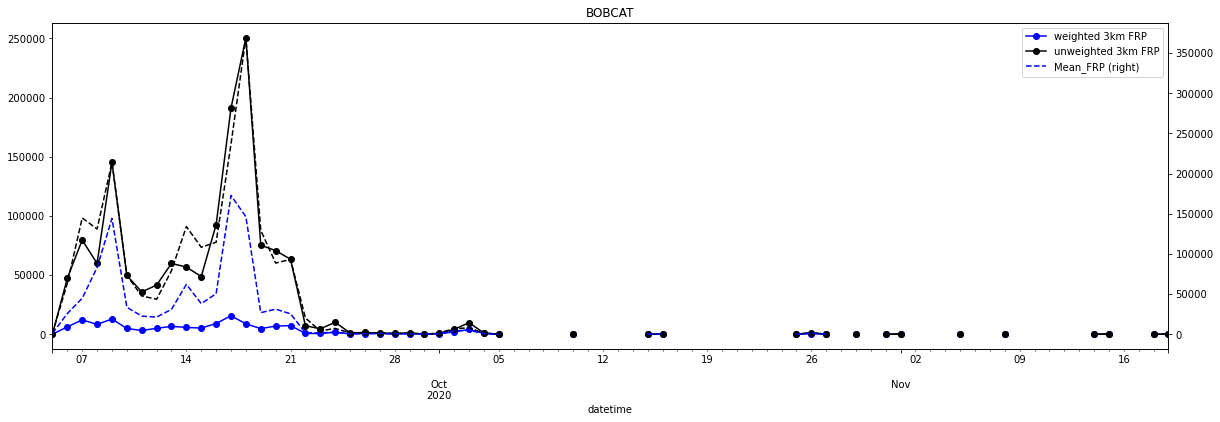

In [123]:
#fire_incidents = ['AUGUST COMPLEX']
fire_incidents = ['BOBCAT']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_old_rave='/data2/lthapa/ML_daily/fire_features/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    sm_weighted = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_Weighted_'+str(start_time)+'Z_day_start.csv')
    sm_weighted['datetime'] = pd.to_datetime(sm_weighted['day'])
    sm_weighted = sm_weighted.set_index(['datetime'])
    sm_weighted = sm_weighted.resample('D').asfreq()
    
    sm_unweighted = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_Unweighted_'+str(start_time)+'Z_day_start.csv')
    sm_unweighted['datetime'] = pd.to_datetime(sm_unweighted['day'])
    sm_unweighted = sm_unweighted.set_index(['datetime'])
    sm_unweighted = sm_unweighted.resample('D').asfreq()
    
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_13kmSum_'+str(start_time)+'Z_day_start.csv')
    rave['datetime'] = pd.to_datetime(rave['day'])
    rave = rave.set_index(['datetime'])
    rave = rave.resample('D').asfreq()
    
    rave_weighted = pd.read_csv(path_features_old_rave+file_prefix+'_Daily_RAVE_'+str(start_time)+'Z_day_start.csv')
    rave_weighted['datetime'] = pd.to_datetime(rave_weighted['day'])
    rave_weighted = rave_weighted.set_index(['datetime'])
    rave_weighted.index = pd.to_datetime(rave_weighted.index.date)
    rave_weighted = rave_weighted.resample('D').asfreq()
    

    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['FRP_MEAN'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['FRP_MEAN'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted 3km FRP','unweighted 3km FRP'])
    rave.plot(y='Mean_FRP',
              figsize=(20,6),style='k--', ax=ax, secondary_y=True)
    rave_weighted.plot(y='Mean_FRP',
              figsize=(20,6),style='b--', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()

# Test weighted vs usweighted SMOPS

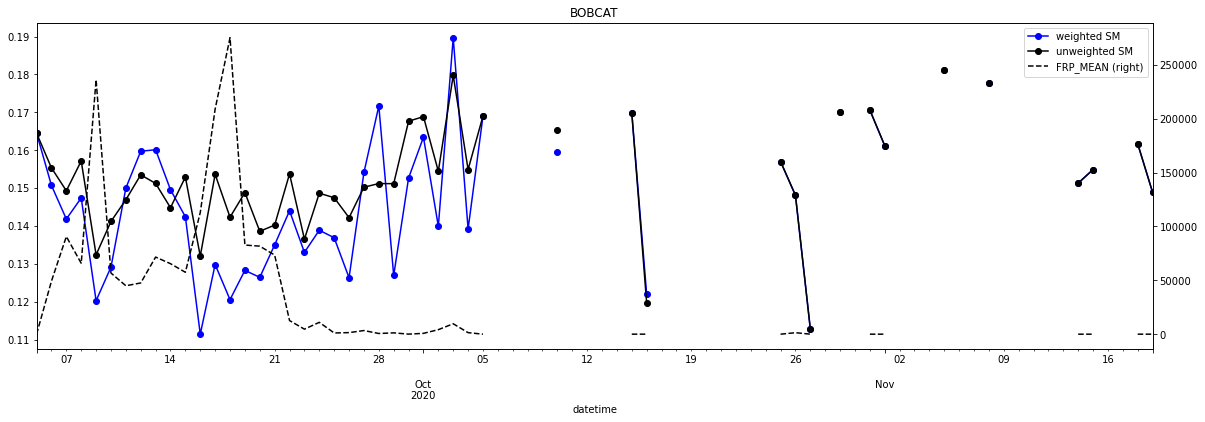

In [51]:
#fire_incidents = ['AUGUST COMPLEX']
fire_incidents = ['BOBCAT']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features_3/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    sm_weighted = pd.read_csv(path_features+file_prefix+'_Daily_SMOPS_Weighted_'+str(start_time)+'Z_day_start.csv')
    sm_weighted['datetime'] = pd.to_datetime(sm_weighted['day'])
    sm_weighted = sm_weighted.set_index(['datetime'])
    sm_weighted = sm_weighted.resample('D').asfreq()
    
    sm_unweighted = pd.read_csv(path_features+file_prefix+'_Daily_SMOPS_Unweighted_'+str(start_time)+'Z_day_start.csv')
    sm_unweighted['datetime'] = pd.to_datetime(sm_unweighted['day'])
    sm_unweighted = sm_unweighted.set_index(['datetime'])
    sm_unweighted = sm_unweighted.resample('D').asfreq()
    
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')
    rave['datetime'] = pd.to_datetime(sm['day'])
    rave = rave.set_index(['datetime'])
    rave = rave.resample('D').asfreq()
    

    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['Blended_SM'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['Blended_SM'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted SM','unweighted SM'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()

# Test weighted vs unweighted PWS

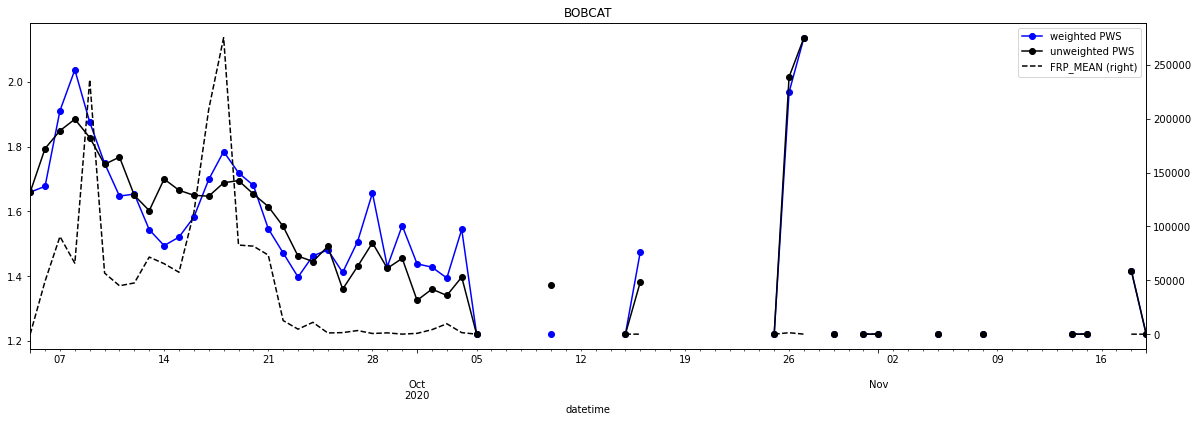

In [56]:
#fire_incidents = ['AUGUST COMPLEX']
fire_incidents = ['BOBCAT']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features_3/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    sm_weighted = pd.read_csv(path_features+file_prefix+'_Daily_PWS_Weighted_'+str(start_time)+'Z_day_start.csv')
    sm_weighted['datetime'] = pd.to_datetime(sm_weighted['day'])
    sm_weighted = sm_weighted.set_index(['datetime'])
    sm_weighted = sm_weighted.resample('D').asfreq()
    
    sm_unweighted = pd.read_csv(path_features+file_prefix+'_Daily_PWS_Unweighted_'+str(start_time)+'Z_day_start.csv')
    sm_unweighted['datetime'] = pd.to_datetime(sm_unweighted['day'])
    sm_unweighted = sm_unweighted.set_index(['datetime'])
    sm_unweighted = sm_unweighted.resample('D').asfreq()
    
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')
    rave['datetime'] = pd.to_datetime(sm['day'])
    rave = rave.set_index(['datetime'])
    rave = rave.resample('D').asfreq()
    

    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['PWS'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['PWS'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted PWS','unweighted PWS'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()

# Test weighted vs unweighted FWI

            IMERG.FINAL.v6_FWI  IMERG.FINAL.v6_FWI
datetime                                          
2020-09-05           59.287724           59.287724
2020-09-06           63.892223           64.231593
2020-09-07           72.439629           72.439629
2020-09-08           67.317505           67.317505
2020-09-09           50.562408           50.562408
2020-09-10           42.146485           42.243869
2020-09-11           52.494801           52.496660
2020-09-12           65.067421           64.972699
2020-09-13           65.031944           64.903915
2020-09-14           53.929124           53.836465
2020-09-15           49.744086           49.729829
2020-09-16           63.671902           63.738716
2020-09-17           77.614617           77.668713
2020-09-18           83.815574           83.892032
2020-09-19           75.076797           75.066511
2020-09-20           63.919781           63.853822
2020-09-21           67.524534           67.482837
2020-09-22           56.937217 

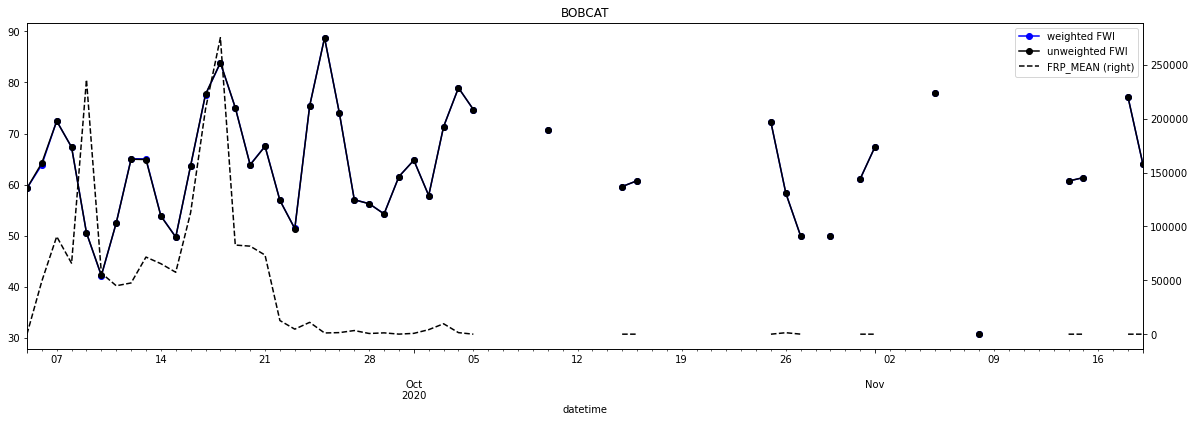

In [63]:
#fire_incidents = ['AUGUST COMPLEX']
fire_incidents = ['BOBCAT']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features_3/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    sm_weighted = pd.read_csv(path_features+file_prefix+'_Daily_FWI_IMERG_Weighted_'+str(start_time)+'Z_day_start.csv')
    sm_weighted['datetime'] = pd.to_datetime(sm_weighted['day'])
    sm_weighted = sm_weighted.set_index(['datetime'])
    sm_weighted = sm_weighted.resample('D').asfreq()
    
    sm_unweighted = pd.read_csv(path_features+file_prefix+'_Daily_FWI_IMERG_Unweighted_'+str(start_time)+'Z_day_start.csv')
    sm_unweighted['datetime'] = pd.to_datetime(sm_unweighted['day'])
    sm_unweighted = sm_unweighted.set_index(['datetime'])
    sm_unweighted = sm_unweighted.resample('D').asfreq()
    print(pd.concat([sm_weighted['IMERG.FINAL.v6_FWI'], sm_unweighted['IMERG.FINAL.v6_FWI']], axis=1))
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')
    rave['datetime'] = pd.to_datetime(sm['day'])
    rave = rave.set_index(['datetime'])
    rave = rave.resample('D').asfreq()
    

    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['IMERG.FINAL.v6_FWI'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['IMERG.FINAL.v6_FWI'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted FWI','unweighted FWI'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()

# Test weighted vs unweighted ESI

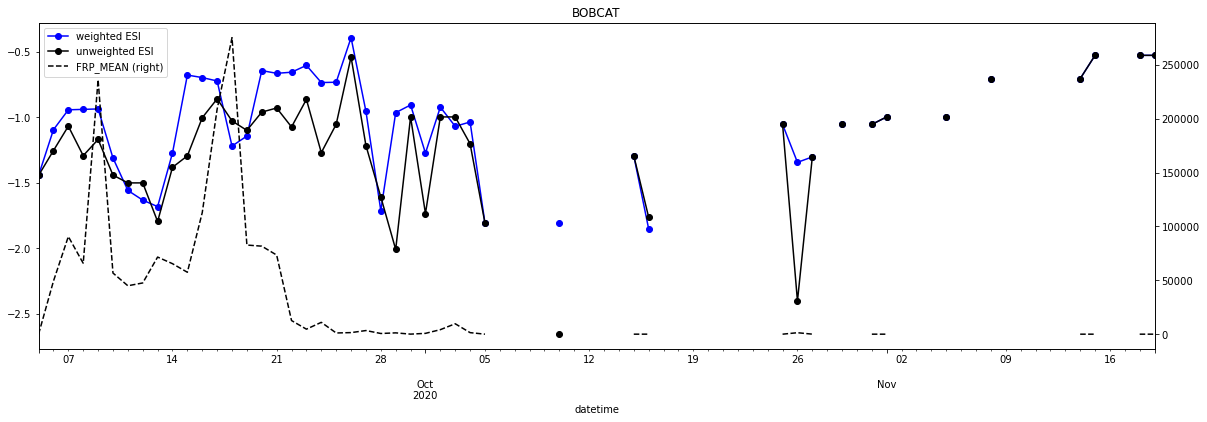

In [72]:
#fire_incidents = ['AUGUST COMPLEX']
fire_incidents = ['BOBCAT']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features_3/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    sm_weighted = pd.read_csv(path_features+file_prefix+'_Daily_ESI_Weighted_'+str(start_time)+'Z_day_start.csv')
    sm_weighted['datetime'] = pd.to_datetime(sm_weighted['day'])
    sm_weighted = sm_weighted.set_index(['datetime'])
    sm_weighted = sm_weighted.resample('D').asfreq()
    
    sm_unweighted = pd.read_csv(path_features+file_prefix+'_Daily_ESI_Unweighted_'+str(start_time)+'Z_day_start.csv')
    sm_unweighted['datetime'] = pd.to_datetime(sm_unweighted['day'])
    sm_unweighted = sm_unweighted.set_index(['datetime'])
    sm_unweighted = sm_unweighted.resample('D').asfreq()
    #print(pd.concat([sm_weighted['IMERG.FINAL.v6_FWI'], sm_unweighted['IMERG.FINAL.v6_FWI']], axis=1))
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')
    rave['datetime'] = pd.to_datetime(sm['day'])
    rave = rave.set_index(['datetime'])
    rave = rave.resample('D').asfreq()
    

    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['ESI'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['ESI'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted ESI','unweighted ESI'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()

# Test weighted and unweighted HDW and HWP

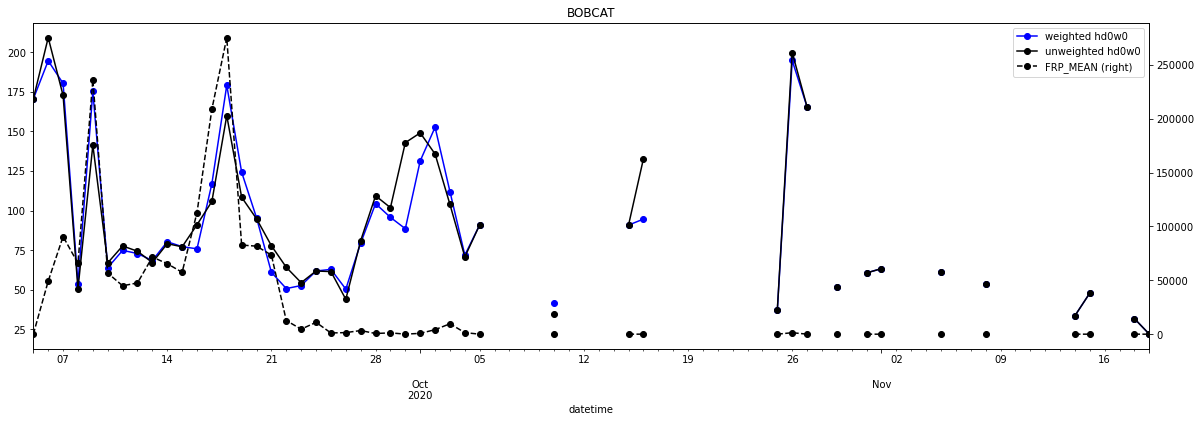

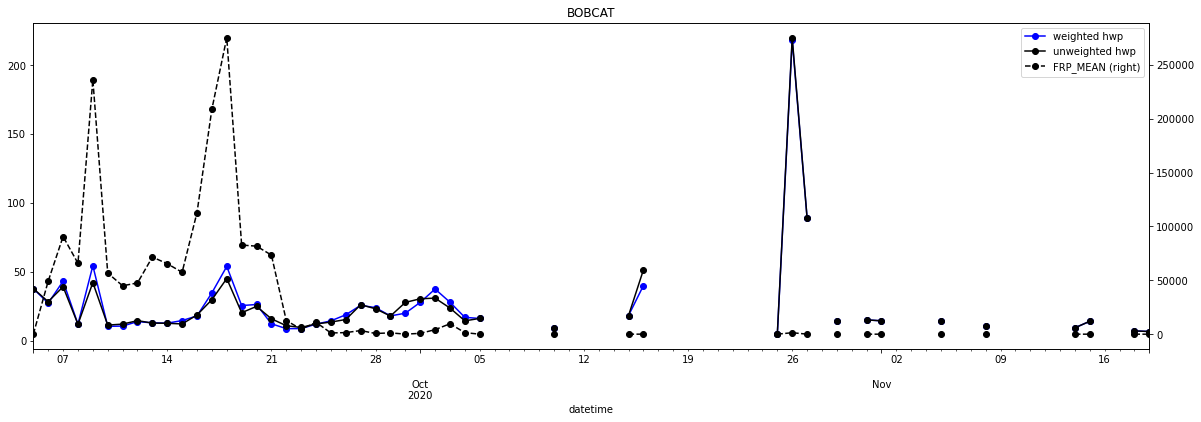

In [170]:
#fire_incidents = ['AUGUST COMPLEX']
fire_incidents = ['BOBCAT']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features_3/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    sm_weighted = pd.read_csv(path_features+file_prefix+'_Daily_HRRR_Weighted_'+str(start_time)+'Z_day_start.csv')
    sm_weighted['datetime'] = pd.to_datetime(sm_weighted['day'])
    sm_weighted = sm_weighted.set_index(['datetime'])
    sm_weighted = sm_weighted.resample('D').asfreq()
    
    sm_unweighted = pd.read_csv(path_features+file_prefix+'_Daily_HRRR_Unweighted_'+str(start_time)+'Z_day_start.csv')
    sm_unweighted['datetime'] = pd.to_datetime(sm_unweighted['day'])
    sm_unweighted = sm_unweighted.set_index(['datetime'])
    sm_unweighted = sm_unweighted.resample('D').asfreq()
    #print(pd.concat([sm_weighted['IMERG.FINAL.v6_FWI'], sm_unweighted['IMERG.FINAL.v6_FWI']], axis=1))
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')
    rave['datetime'] = pd.to_datetime(sm['day'])
    rave = rave.set_index(['datetime'])
    rave = rave.resample('D').asfreq()
    

    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['hd0w0'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['hd0w0'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted hd0w0','unweighted hd0w0'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--o', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['hwp'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['hwp'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted hwp','unweighted hwp'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--o', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()

# Test weighted and unweighted Fuel Density

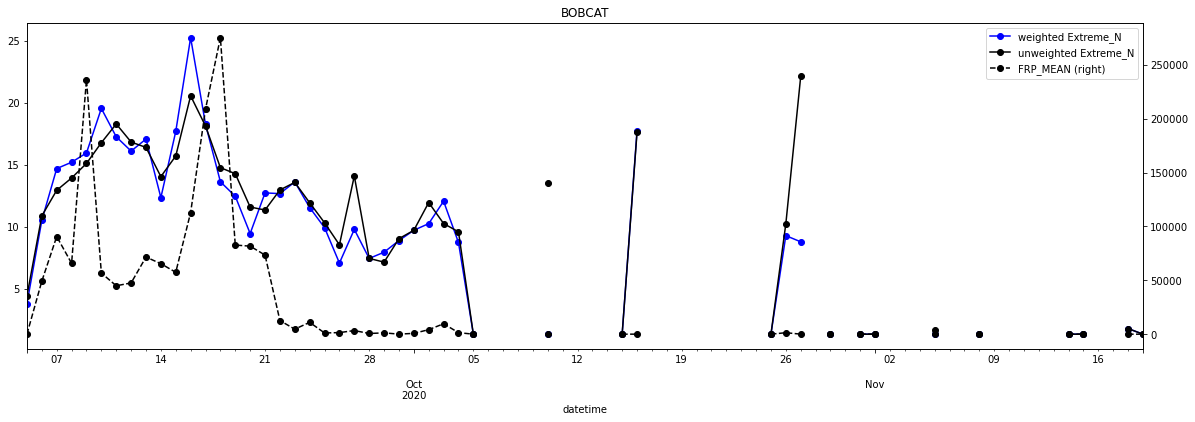

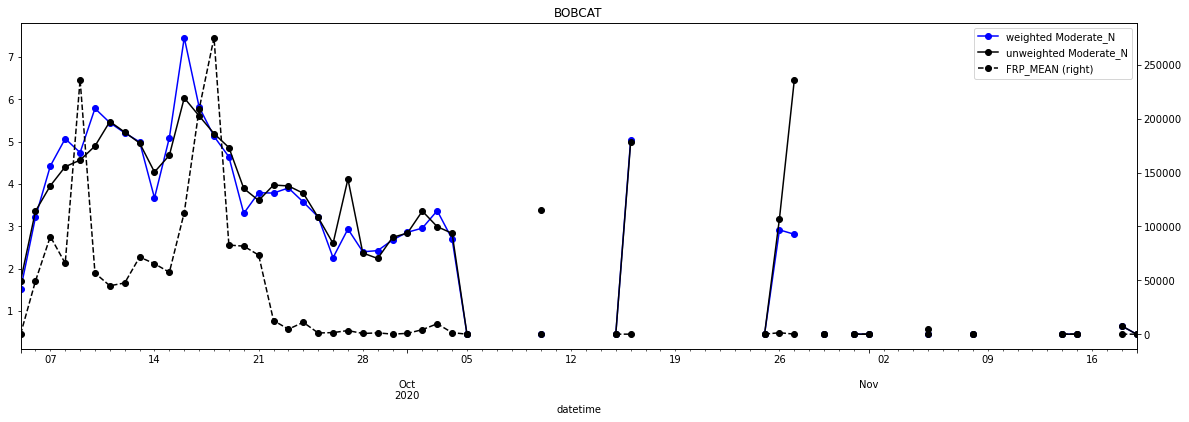

In [174]:
#fire_incidents = ['AUGUST COMPLEX']
fire_incidents = ['BOBCAT']
path_features='/data2/lthapa/ML_daily/fire_features_3/'
path_features_coarse='/data2/lthapa/ML_daily/fire_features_3/'

start_time=12

for ii in range(len(fire_incidents)):
    file_prefix = fire_incidents[ii].lower().replace(' ', '_')
    sm_weighted = pd.read_csv(path_features+file_prefix+'_Daily_FUEL_LOADING_Weighted_'+str(start_time)+'Z_day_start.csv')
    sm_weighted['datetime'] = pd.to_datetime(sm_weighted['day'])
    sm_weighted = sm_weighted.set_index(['datetime'])
    sm_weighted = sm_weighted.resample('D').asfreq()
    
    sm_unweighted = pd.read_csv(path_features+file_prefix+'_Daily_FUEL_LOADING_Unweighted_'+str(start_time)+'Z_day_start.csv')
    sm_unweighted['datetime'] = pd.to_datetime(sm_unweighted['day'])
    sm_unweighted = sm_unweighted.set_index(['datetime'])
    sm_unweighted = sm_unweighted.resample('D').asfreq()
    #print(pd.concat([sm_weighted['IMERG.FINAL.v6_FWI'], sm_unweighted['IMERG.FINAL.v6_FWI']], axis=1))
    rave = pd.read_csv(path_features+file_prefix+'_Daily_RAVE_3kmSum_'+str(start_time)+'Z_day_start.csv')
    rave['datetime'] = pd.to_datetime(sm['day'])
    rave = rave.set_index(['datetime'])
    rave = rave.resample('D').asfreq()
    

    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['Extreme_N'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['Extreme_N'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted Extreme_N','unweighted Extreme_N'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--o', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20,15)) 
    sm_weighted.plot(y=['Moderate_N'],
                            figsize=(20,6),style='bo-',ax=ax)
    sm_unweighted.plot(y=['Moderate_N'],
                            figsize=(20,6),style='ko-',ax=ax)
    plt.legend(['weighted Moderate_N','unweighted Moderate_N'])
    rave.plot(y='FRP_MEAN',
              figsize=(20,6),style='k--o', ax=ax, secondary_y=True)
    
    #h1, l1 = ax.get_legend_handles_labels()
    #ax.legend(h1, l1,bbox_to_anchor=(1.1, 1), loc='upper left')
    
    plt.title(fire_incidents[ii])
    plt.show()